''' **OUARMA** Issouf '''

Stage Data Sciencist

Projet Big Data


***Etape 1: Importation des données***

    *** Des libarairies utiles ***

In [169]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer 
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel 
from pyspark.ml import Pipeline, PipelineModel 
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

spark = (SparkSession.builder
         .master('local')
         .appName('Demo full pipeline')
         .getOrCreate())


Importation des données et l'appeler datadf

In [2]:
datadf = spark.read.options(header='True', inferSchema='True').format("csv").load("Loan.csv")

**Voir le schéma de la base de données:**


L'observation du schéma montre différents types de données:
- des données de type entier (integer) donc numériques
   - dans les données de types integer il y a des données catégorielles (comme le status voir description)
- des données de type caractère (string) donc non numériques
- des données de type double

In [ ]:
datadf.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- loan_limit: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- approv_in_adv: string (nullable = true)
 |-- loan_type: string (nullable = true)
 |-- loan_purpose: string (nullable = true)
 |-- Credit_Worthiness: string (nullable = true)
 |-- open_credit: string (nullable = true)
 |-- business_or_commercial: string (nullable = true)
 |-- loan_amount: integer (nullable = true)
 |-- rate_of_interest: double (nullable = true)
 |-- Interest_rate_spread: double (nullable = true)
 |-- Upfront_charges: double (nullable = true)
 |-- term: double (nullable = true)
 |-- Neg_ammortization: string (nullable = true)
 |-- interest_only: string (nullable = true)
 |-- lump_sum_payment: string (nullable = true)
 |-- property_value: double (nullable = true)
 |-- construction_type: string (nullable = true)
 |-- occupancy_type: string (nullable = true)
 |-- Secured_by: string (nullable = true)
 |-- total_unit

**Resumé des types de données**

In [18]:
datadf.dtypes

[('ID', 'int'),
 ('year', 'int'),
 ('loan_limit', 'string'),
 ('Gender', 'string'),
 ('approv_in_adv', 'string'),
 ('loan_type', 'string'),
 ('loan_purpose', 'string'),
 ('Credit_Worthiness', 'string'),
 ('open_credit', 'string'),
 ('business_or_commercial', 'string'),
 ('loan_amount', 'int'),
 ('rate_of_interest', 'double'),
 ('Interest_rate_spread', 'double'),
 ('Upfront_charges', 'double'),
 ('term', 'double'),
 ('Neg_ammortization', 'string'),
 ('interest_only', 'string'),
 ('lump_sum_payment', 'string'),
 ('property_value', 'double'),
 ('construction_type', 'string'),
 ('occupancy_type', 'string'),
 ('Secured_by', 'string'),
 ('total_units', 'string'),
 ('income', 'double'),
 ('credit_type', 'string'),
 ('Credit_Score', 'int'),
 ('co-applicant_credit_type', 'string'),
 ('age', 'string'),
 ('submission_of_application', 'string'),
 ('LTV', 'double'),
 ('Region', 'string'),
 ('Security_Type', 'string'),
 ('Status', 'int'),
 ('dtir1', 'double')]

Voir les 10 premières lignes de la base de données

In [5]:
datadf.show(10)


+-----+----+----------+-----------------+-------------+---------+------------+-----------------+-----------+----------------------+-----------+----------------+--------------------+---------------+-----+-----------------+-------------+----------------+--------------+-----------------+--------------+----------+-----------+-------+-----------+------------+------------------------+-----+-------------------------+-----------+-------+-------------+------+-----+
|   ID|year|loan_limit|           Gender|approv_in_adv|loan_type|loan_purpose|Credit_Worthiness|open_credit|business_or_commercial|loan_amount|rate_of_interest|Interest_rate_spread|Upfront_charges| term|Neg_ammortization|interest_only|lump_sum_payment|property_value|construction_type|occupancy_type|Secured_by|total_units| income|credit_type|Credit_Score|co-applicant_credit_type|  age|submission_of_application|        LTV| Region|Security_Type|Status|dtir1|
+-----+----+----------+-----------------+-------------+---------+------------+

Format pandas pour avoir une autre disposition des données

In [3]:
pndasDF = datadf.toPandas()


In [5]:
pndasDF

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0


In [ ]:
Nous avons au total 34 colonnes et 148670 lignes

**Exploration**:
Description

Les colonnes

In [40]:
datadf.columns

['ID',
 'year',
 'loan_limit',
 'Gender',
 'approv_in_adv',
 'loan_type',
 'loan_purpose',
 'Credit_Worthiness',
 'open_credit',
 'business_or_commercial',
 'loan_amount',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'Neg_ammortization',
 'interest_only',
 'lump_sum_payment',
 'property_value',
 'construction_type',
 'occupancy_type',
 'Secured_by',
 'total_units',
 'income',
 'credit_type',
 'Credit_Score',
 'co-applicant_credit_type',
 'age',
 'submission_of_application',
 'LTV',
 'Region',
 'Security_Type',
 'Status',
 'dtir1']

Les colonnes numériques

In [4]:
numcol=['ID',  'year',  'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges',  
        'term', 'property_value', 'income', 'Credit_Score',  'LTV', 'Status', 'dtir1']

Les colonnes non numériques

In [5]:
carcol=['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',  'Credit_Worthiness', 
        'open_credit',  'business_or_commercial', 'Neg_ammortization', 'interest_only', 
        'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by','total_units', 'credit_type', 
        'co-applicant_credit_type','age', 'submission_of_application', 'Region', 'Security_Type']

Description colonnes non numériques

In [6]:
datadf.describe(*carcol).show(vertical=True)

-RECORD 0--------------------------------------
 summary                   | count             
 loan_limit                | 145326            
 Gender                    | 148670            
 approv_in_adv             | 147762            
 loan_type                 | 148670            
 loan_purpose              | 148536            
 Credit_Worthiness         | 148670            
 open_credit               | 148670            
 business_or_commercial    | 148670            
 Neg_ammortization         | 148549            
 interest_only             | 148670            
 lump_sum_payment          | 148670            
 construction_type         | 148670            
 occupancy_type            | 148670            
 Secured_by                | 148670            
 total_units               | 148670            
 credit_type               | 148670            
 co-applicant_credit_type  | 148670            
 age                       | 148470            
 submission_of_application | 148670     

- On constate qu'il n'y a ni de moyenne ni de variance.

- A chaque attribut on a le nombre d'observations, le max et le min. Nous allons voir cela avec des graphiques.

- On observe aussi que les variables  loan_limit |145326  et  approv_in_adv |147762 ont moins d'observations que les autres| 148670.   
- Les variables credit_type et co-applicant_credit_type semblent avoir les mêmes modalités même min et même max: est-ce une redondance d'informations? Dans l'affirmative, une des variables peut apporter déjà assez d'informations sur l'autre. Nous vérifirons cela avec les corrélations

**Description des valeurs non numériques**

In [7]:
datadf.describe(*numcol).show(vertical=True)

-RECORD 0-----------------------------------
 summary              | count               
 ID                   | 148670              
 year                 | 148670              
 loan_amount          | 148670              
 rate_of_interest     | 112231              
 Interest_rate_spread | 112031              
 Upfront_charges      | 109028              
 term                 | 148629              
 property_value       | 133572              
 income               | 139520              
 Credit_Score         | 148670              
 LTV                  | 133572              
 Status               | 148670              
 dtir1                | 124549              
-RECORD 1-----------------------------------
 summary              | mean                
 ID                   | 99224.5             
 year                 | 2019.0              
 loan_amount          | 331117.7439967714   
 rate_of_interest     | 4.045475804366537   
 Interest_rate_spread | 0.4416556604868321  
 Upfront_c

- Les variables n'ont pas le même nombre d'observations. Seules 4 variables ont le total (148670) des observations. Les autres, au nombre de 8, en ont moins. 
- On peut aussi remarquer que les variables numériques, moins nombreuses que les variables non numériques, sont plus concernées par le problème des données manquantes.

- Lorsqu'on observe les échelles de distribution des variables, on peut constater qu'elles sont remarquablement différentes.  Par exemple,  property_value a une valeur max de 1.6508E7 (min 8000.0)  alors que Interest_rate_spread a une valeur max de 3.357  (min -3.638)

- Lorqu'on observe la variance (la variation de l'information selon les individus), la variance de l'année est nulle. Ce qui indique, qu'elle n'apporte pas d'informations qui permettent de distinguer les différentes situations considérées dans nos données
- Les taux d'intéret sont les informations qui varient le moins | 0.5 entre les individus par rapport aux autres informations (variables numériques) de cette base de données (sans considérer status). 
- La valeur de la propriété 359935.315561945 , le montant de l'emprunt | 183909.3101270869, le revenu | 6496.586382220226 et les frais (Upfront_charges) | 3251.121509710332  sont les variables qui varient le plus entre les individus. Ces variables semblent apporter le plus d'informations sur la différence de situation entre les individus de la base (par rapport aux autres variables). Est-ce l'effet possible d'outliers?
- ID est une variable qui n'apporte pas une information intrinsecte, sa variance ne nous interesse pas.  
- La variable status est un variable binaire (0,1) avec une moyenne de 0,24 et une variance de 0,43. Cela souligne que la modalité 1 represente 24% de l'ensemble des occurrences de la variable.



**En résumé :**
- Les variables year et ID n'apportent pas d'informations indispensables. 
    - Elle peuvent être ignorées. 
- Ensuite, certaines variables numériques apportent plus d'informations différentielles que les autres. 
    - Toutefois, la disponibilté des données pour l'ensemble des individus ainsi que la redondance éventuelle des informations sont aussi importantes pour faire un choix entre elles. 

**************BASE DE DONNEES SANS ID ET YEAR**************

In [6]:
df1=datadf.drop('ID','year') 
pndaDF = df1.toPandas()

***Les valeurs manquantes pour chaque variable***

In [9]:
from pyspark.sql.functions import isnan, when, count, col
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show(vertical=True)


-RECORD 0--------------------------
 loan_limit                | 3344  
 Gender                    | 0     
 approv_in_adv             | 908   
 loan_type                 | 0     
 loan_purpose              | 134   
 Credit_Worthiness         | 0     
 open_credit               | 0     
 business_or_commercial    | 0     
 loan_amount               | 0     
 rate_of_interest          | 36439 
 Interest_rate_spread      | 36639 
 Upfront_charges           | 39642 
 term                      | 41    
 Neg_ammortization         | 121   
 interest_only             | 0     
 lump_sum_payment          | 0     
 property_value            | 15098 
 construction_type         | 0     
 occupancy_type            | 0     
 Secured_by                | 0     
 total_units               | 0     
 income                    | 9150  
 credit_type               | 0     
 Credit_Score              | 0     
 co-applicant_credit_type  | 0     
 age                       | 200   
 submission_of_application |

- Les variables  Upfront_charges | 39642,  rate_of_interest | 36439 , Interest_rate_spread | 36639  sont les variables avec le plus de données manquantes.  
    - En rappel, les intérêts apportent aussi une faible variance d'informations. Elles semblent être candidates pour une mise à l'écart. 
    - Si en plus il y a des variables qui sont corrélées à elles avec le moins de soucis d'informations, cette mise en écart nous semble un choix compréhensible.
    - Toutefois, la variable Upfront_charges a une variance d'informations considérable pour les individus pour lesquels ses valeurs sont connues.
- Ensuite, les variables  dtir1 | 24121,  LTV et property_value  même nombre (est-ce une évolution corrélée?)| 15098,  income | 9150,  loan_limit | 3344 et approv_in_adv | 908  sont celles qui ont le plus de données manquantes après le premier groupe.   


 
 Gender                    | 0     
  
 loan_type                 | 0     
 loan_purpose              | 134   
 Credit_Worthiness         | 0     
 open_credit               | 0     
 business_or_commercial    | 0     
 loan_amount               | 0     
 
 term                      | 41    
 Neg_ammortization         | 121   
 interest_only             | 0     
 lump_sum_payment          | 0     

 occupancy_type            | 0     
 total_units               | 0      
 credit_type               | 0     
 Credit_Score              | 0     
 co-applicant_credit_type  | 0     
 age                       | 200   
 submission_of_application | 0     
 Region                    | 0     
 Security_Type             | 0     
 Status                    | 0     


In [ ]:
###Voir d'autres détails###

###datadf.groupBy("ID").count().show()

In [11]:
df1.describe("Gender").show()
df1.groupBy("Gender").count().show()
df1.groupBy("Status").count().show()
df1.groupBy("loan_limit").count().show()
df1.groupBy("Region").count().show()
df1.groupBy("age").count().show()
df1.groupBy("approv_in_adv").count().show()                 
df1.groupBy("loan_type").count().show()              
df1.groupBy("loan_purpose").count().show()
df1.groupBy("Credit_Worthiness").count().show()  
df1.groupBy("open_credit").count().show()                
df1.groupBy("business_or_commercial").count().show()     
df1.groupBy("loan_amount").count().show()                
df1.groupBy("rate_of_interest").count().show()          
df1.groupBy("Interest_rate_spread").count().show()      
df1.groupBy("Upfront_charges").count().show()            
df1.groupBy("term").count().show() 
df1.groupBy("Neg_ammortization").count().show() 
df1.groupBy("interest_only").count().show() 
df1.groupBy("lump_sum_payment").count().show() 
df1.groupBy("property_value").count().show()  
df1.groupBy("construction_type").count().show() 
df1.groupBy("occupancy_type").count().show() 
df1.groupBy("Secured_by").count().show() 
df1.groupBy("total_units").count().show() 
df1.groupBy("income").count().show() 
df1.groupBy("credit_type").count().show() 
df1.groupBy("Credit_Score").count().show() 
df1.groupBy("co-applicant_credit_type").count().show() 
df1.groupBy("age").count().show() 
df1.groupBy("submission_of_application").count().show() 
df1.groupBy("LTV").count().show()  
df1.groupBy("Region").count().show() 
df1.groupBy("Security_Type").count().show()  
df1.groupBy("Status").count().show()  
df1.groupBy("dtir1").count().show() 

+-------------+------+
|approv_in_adv| count|
+-------------+------+
|         null|   908|
|        nopre|124621|
|          pre| 23141|
+-------------+------+

+---------+------+
|loan_type| count|
+---------+------+
|    type3| 14735|
|    type1|113173|
|    type2| 20762|
+---------+------+

+------------+-----+
|loan_purpose|count|
+------------+-----+
|        null|  134|
|          p2| 3274|
|          p1|34529|
|          p3|55934|
|          p4|54799|
+------------+-----+

+-----------------+------+
|Credit_Worthiness| count|
+-----------------+------+
|               l1|142344|
|               l2|  6326|
+-----------------+------+

+-----------+------+
|open_credit| count|
+-----------+------+
|        opc|   556|
|       nopc|148114|
+-----------+------+

+----------------------+------+
|business_or_commercial| count|
+----------------------+------+
|                 nob/c|127908|
|                   b/c| 20762|
+----------------------+------+

+-----------+-----+
|loan_amoun

In [41]:
datadf.groupBy("approv_in_adv").count().show()                 
datadf.groupBy("loan_type").count().show()              
datadf.groupBy("loan_purpose").count().show()
datadf.groupBy("Credit_Worthiness").count().show()  
datadf.groupBy("open_credit").count().show()                
datadf.groupBy("business_or_commercial").count().show()     
datadf.groupBy("loan_amount").count().show()                
datadf.groupBy("rate_of_interest").count().show()          
datadf.groupBy("Interest_rate_spread").count().show()      
datadf.groupBy("Upfront_charges").count().show()            
datadf.groupBy("term").count().show() 
datadf.groupBy("Neg_ammortization").count().show() 
datadf.groupBy("interest_only").count().show() 
datadf.groupBy("lump_sum_payment").count().show() 
datadf.groupBy("property_value").count().show()  
datadf.groupBy("construction_type").count().show() 
datadf.groupBy("occupancy_type").count().show() 
datadf.groupBy("Secured_by").count().show() 
datadf.groupBy("total_units").count().show() 
datadf.groupBy("income").count().show() 
datadf.groupBy("credit_type").count().show() 
datadf.groupBy("Credit_Score").count().show() 
datadf.groupBy("co-applicant_credit_type").count().show() 
datadf.groupBy("age").count().show() 
datadf.groupBy("submission_of_application").count().show() 
datadf.groupBy("LTV").count().show()  
datadf.groupBy("Region").count().show() 
datadf.groupBy("Security_Type").count().show()  
datadf.groupBy("Status").count().show()  
datadf.groupBy("dtir1").count().show() 

+-------------+------+
|approv_in_adv| count|
+-------------+------+
|         null|   908|
|        nopre|124621|
|          pre| 23141|
+-------------+------+

+---------+------+
|loan_type| count|
+---------+------+
|    type3| 14735|
|    type1|113173|
|    type2| 20762|
+---------+------+

+------------+-----+
|loan_purpose|count|
+------------+-----+
|        null|  134|
|          p2| 3274|
|          p1|34529|
|          p3|55934|
|          p4|54799|
+------------+-----+

+-----------------+------+
|Credit_Worthiness| count|
+-----------------+------+
|               l1|142344|
|               l2|  6326|
+-----------------+------+

+-----------+------+
|open_credit| count|
+-----------+------+
|        opc|   556|
|       nopc|148114|
+-----------+------+

+----------------------+------+
|business_or_commercial| count|
+----------------------+------+
|                 nob/c|127908|
|                   b/c| 20762|
+----------------------+------+

+-----------+-----+
|loan_amoun

In [12]:
datadf.groupBy("approv_in_adv").count().show()                 
datadf.groupBy("loan_type").count().show()              
datadf.groupBy("loan_purpose").count().show()
datadf.groupBy("Credit_Worthiness").count().show()  
datadf.groupBy("open_credit").count().show()                
datadf.groupBy("business_or_commercial").count().show()     
datadf.groupBy("loan_amount").count().show()                
datadf.groupBy("rate_of_interest").count().show()          
datadf.groupBy("Interest_rate_spread").count().show()      
datadf.groupBy("Upfront_charges").count().show()            
datadf.groupBy("term").count().show() 
datadf.groupBy("Neg_ammortization").count().show() 
datadf.groupBy("interest_only").count().show() 
datadf.groupBy("lump_sum_payment").count().show() 
datadf.groupBy("property_value").count().show()  
datadf.groupBy("construction_type").count().show() 
datadf.groupBy("occupancy_type").count().show() 
datadf.groupBy("Secured_by").count().show() 
datadf.groupBy("total_units").count().show() 
datadf.groupBy("income").count().show() 
datadf.groupBy("credit_type").count().show() 
datadf.groupBy("Credit_Score").count().show() 
datadf.groupBy("co-applicant_credit_type").count().show() 
datadf.groupBy("age").count().show() 
datadf.groupBy("submission_of_application").count().show() 
datadf.groupBy("LTV").count().show()  
datadf.groupBy("Region").count().show() 
datadf.groupBy("Security_Type").count().show()  
datadf.groupBy("Status").count().show()  
datadf.groupBy("dtir1").count().show() 

+-------------+------+
|approv_in_adv| count|
+-------------+------+
|         null|   908|
|        nopre|124621|
|          pre| 23141|
+-------------+------+

+---------+------+
|loan_type| count|
+---------+------+
|    type3| 14735|
|    type1|113173|
|    type2| 20762|
+---------+------+

+------------+-----+
|loan_purpose|count|
+------------+-----+
|        null|  134|
|          p2| 3274|
|          p1|34529|
|          p3|55934|
|          p4|54799|
+------------+-----+

+-----------------+------+
|Credit_Worthiness| count|
+-----------------+------+
|               l1|142344|
|               l2|  6326|
+-----------------+------+

+-----------+------+
|open_credit| count|
+-----------+------+
|        opc|   556|
|       nopc|148114|
+-----------+------+

+----------------------+------+
|business_or_commercial| count|
+----------------------+------+
|                 nob/c|127908|
|                   b/c| 20762|
+----------------------+------+

+-----------+-----+
|loan_amoun

**Visualisation**

<AxesSubplot:xlabel='age', ylabel='Probability'>

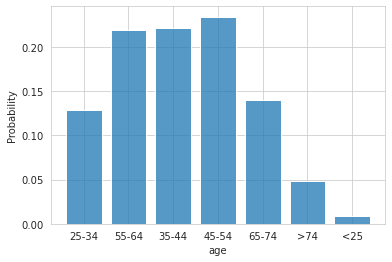

In [10]:
sns.set_style('whitegrid')
sns.histplot(x='age',data=pndasDF, stat="probability",shrink=.8)

- Les plus de 74 ans et les moins de 25 ans sont relativement moins nombreux dans la base. 
- Au regard de cet graphique, nous supposerons que cette variable ne pose pas un problème serieux problème d'outliers 

<AxesSubplot:xlabel='Status', ylabel='Probability'>

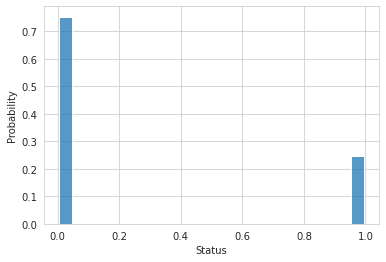

In [127]:
sns.histplot(x='Status',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='Status'>

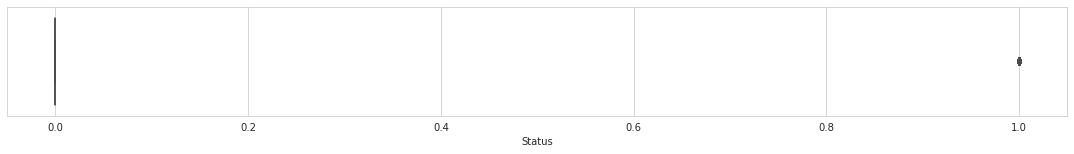

In [65]:
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='Status',data=pndasDF,color="red",orient="h")

<AxesSubplot:xlabel='dtir1', ylabel='Probability'>

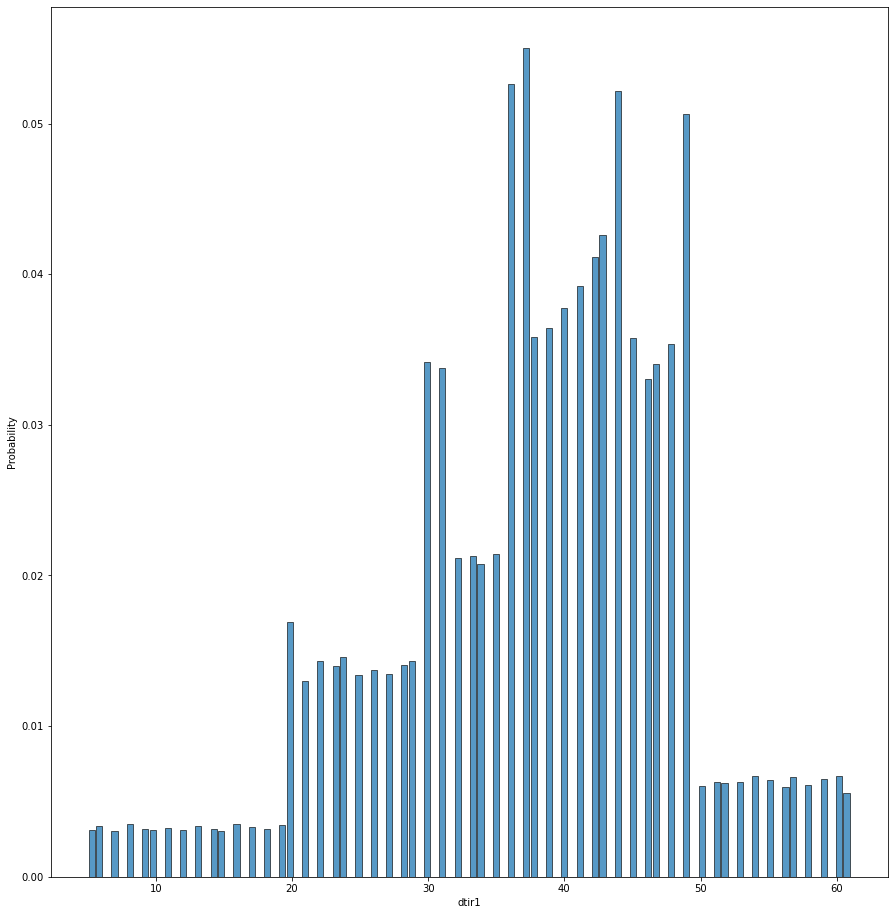

In [125]:
plt.figure(figsize=(15,16))
sns.histplot(x='dtir1',data=pndasDF, stat="probability",shrink=.8)



<AxesSubplot:xlabel='dtir1'>

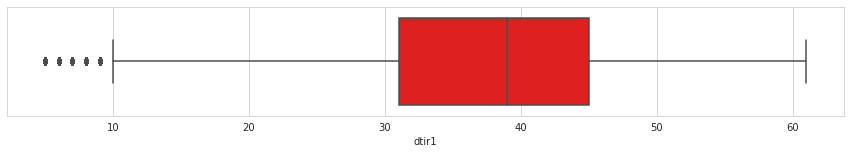

In [64]:
plt.figure(figsize=(15,2))
sns.set_style('whitegrid')
sns.boxplot(x='dtir1',data=pndasDF,color="red",orient="h")

In [67]:
from pyspark.sql.functions import count

In [72]:
df1.select('dtir1').where(df1.dtir1<10).count()

2013

Nous perdons 2013 observations en filtrant (dtir1>10)

<AxesSubplot:xlabel='credit_type', ylabel='Probability'>

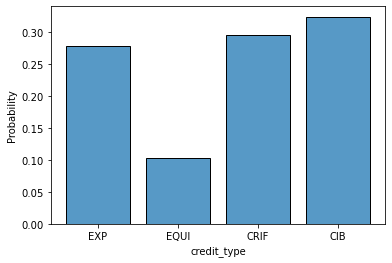

In [123]:
sns.histplot(x='credit_type',data=pndasDF, stat="probability",shrink=.8)


Toutes les modalités ont au moins 10% de chance d'être représentée dans un échantillon

<AxesSubplot:xlabel='credit_type', ylabel='Probability'>

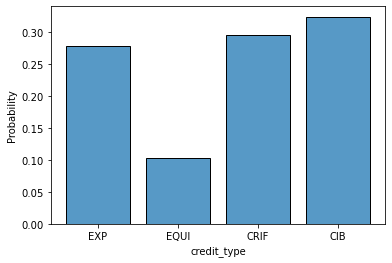

In [121]:
sns.histplot(x='credit_type',data=pndasDF, stat="probability",shrink=.8)


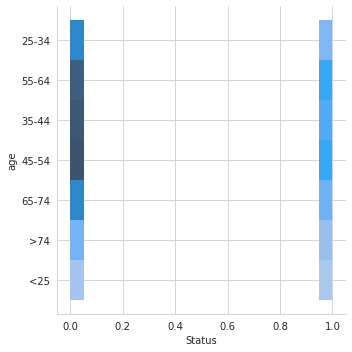

In [59]:
sns.displot(y='age',x='Status',data=pndasDF)

<AxesSubplot:xlabel='credit_type', ylabel='Probability'>

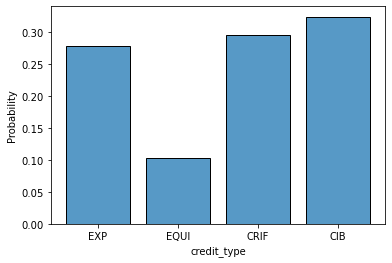

In [120]:
sns.histplot(x='credit_type',data=pndasDF, stat="probability",shrink=.8)

In [ ]:
sns.countplot(x='Interest_rate_spread',data=pndasDF)

<AxesSubplot:xlabel='Region', ylabel='Probability'>

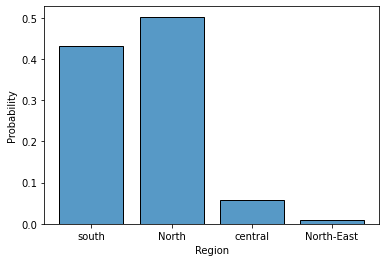

In [117]:
sns.histplot(x='Region',data=pndasDF, stat="probability",shrink=.8)

Le Nord-Est est très peu représenté

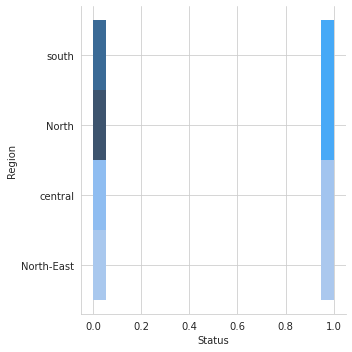

In [83]:
sns.displot(y='Region',x='Status',data=pndasDF)

<AxesSubplot:xlabel='Status', ylabel='submission_of_application'>

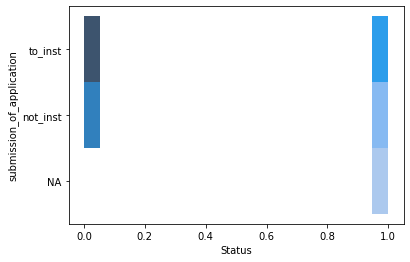

In [115]:
sns.histplot(y='submission_of_application',x='Status',data=pndasDF, stat="probability",shrink=9.8)

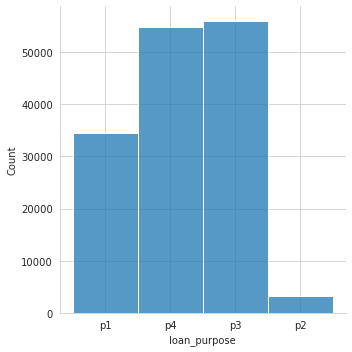

In [ ]:
sns.displot(x='loan_purpose',y='Status',data=pndasDF)

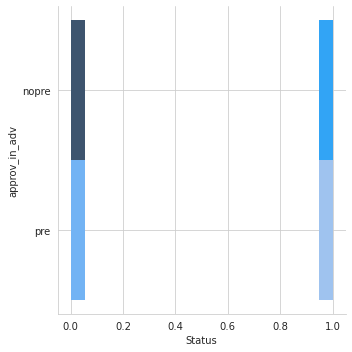

In [73]:
sns.displot(y='approv_in_adv',x='Status',data=pndasDF) 

<AxesSubplot:xlabel='approv_in_adv', ylabel='Probability'>

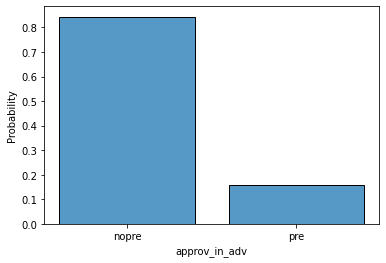

In [114]:
sns.histplot(x="approv_in_adv", data=pndasDF, stat="probability",shrink=.8)                

<AxesSubplot:xlabel='loan_type', ylabel='Probability'>

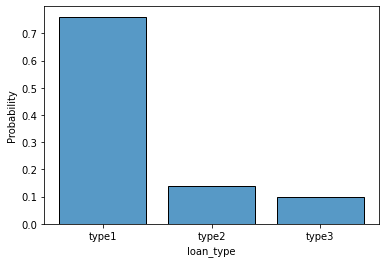

In [112]:
sns.histplot(x="loan_type", data=pndasDF, stat="probability",shrink=.8)                     

<AxesSubplot:xlabel='loan_purpose', ylabel='Probability'>

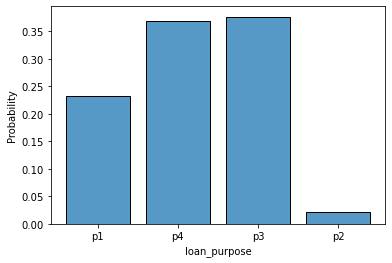

In [110]:
sns.histplot(x='loan_purpose',data=pndasDF, stat="probability",shrink=.8)     

<AxesSubplot:xlabel='Credit_Worthiness', ylabel='Probability'>

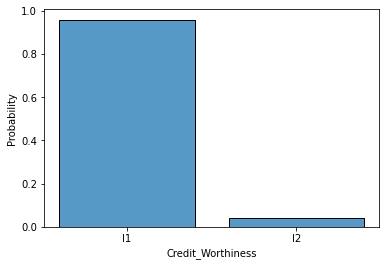

In [109]:
sns.histplot(x='Credit_Worthiness',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='open_credit', ylabel='Probability'>

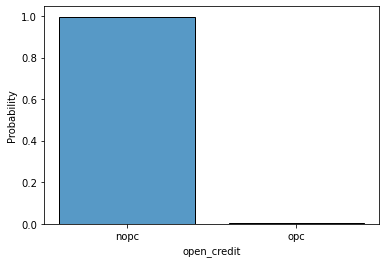

In [106]:
sns.histplot(x='open_credit',data=pndasDF, stat="probability",shrink=.8)                

Peu informatif sur la différence. Envisager une non prise en compte

<AxesSubplot:xlabel='business_or_commercial', ylabel='Probability'>

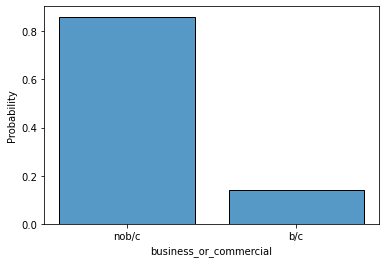

In [104]:
sns.histplot(x='business_or_commercial',data=pndasDF, stat="probability",shrink=.8)    

<AxesSubplot:xlabel='loan_amount', ylabel='Probability'>

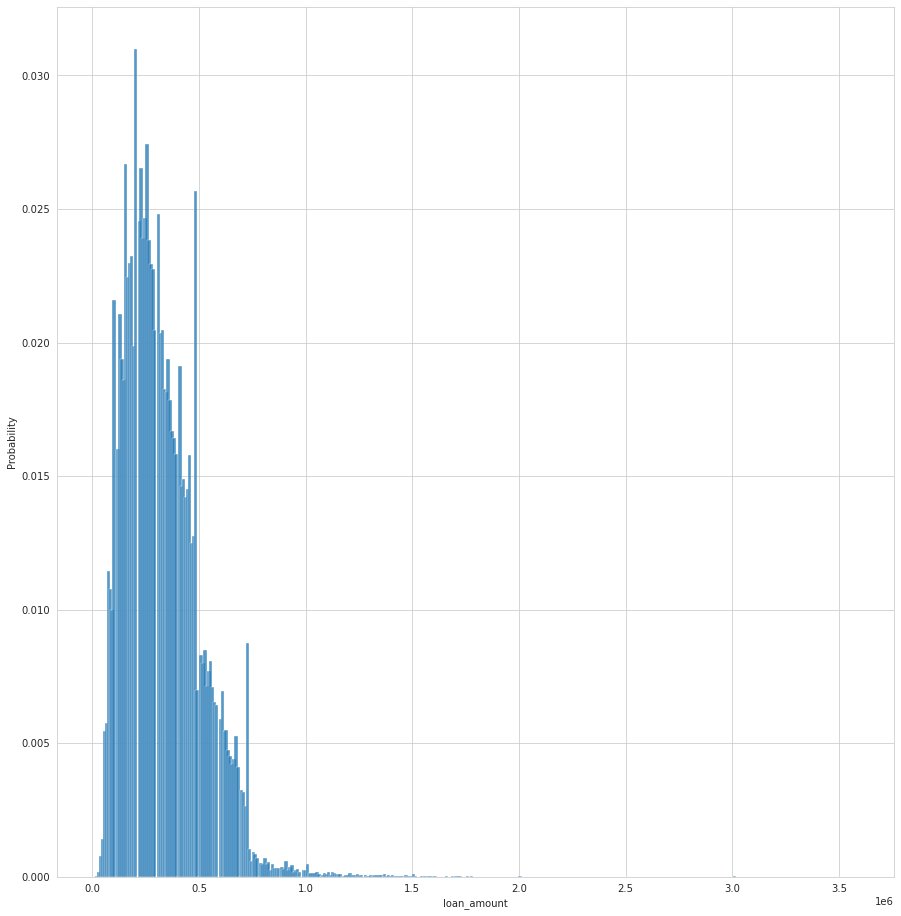

In [128]:
plt.figure(figsize=(15,16))
sns.histplot(x='loan_amount',data=pndasDF, stat="probability",shrink=1.8)            

Si pris en compte, faire un filtre <1,5

In [110]:
datadf.describe("loan_amount").show()

+-------+-----------------+
|summary|      loan_amount|
+-------+-----------------+
|  count|           148670|
|   mean|331117.7439967714|
| stddev|183909.3101270869|
|    min|            16500|
|    max|          3576500|
+-------+-----------------+



In [28]:
#freqla = datadf.stat.approxQuantile("loan_amount", [0.0,0.25,0.5,0.75,1.0],0.0)
#print(freqla)

<AxesSubplot:xlabel='loan_amount'>

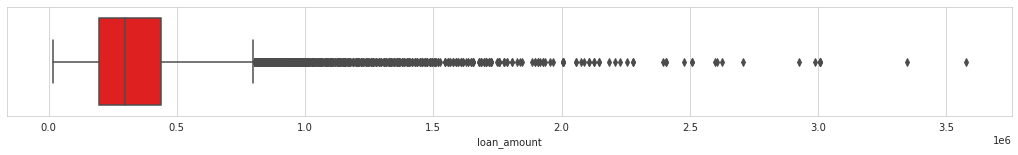

In [63]:
plt.figure(figsize=(18,2))
sns.set_style('whitegrid')
sns.boxplot(x='loan_amount',data=pndasDF,color="red",orient="h")

In [123]:
from pyspark.sql.functions import col , upper , initcap
from pyspark.sql.types import *

In [ ]:
lam=df1.select(col("loan_amount").cast("int"))

In [135]:
dflam1=df1.select('loan_amount').where(df1.loan_amount<1e6)#.count()# la valeur 1e6 brouille la caractère numérique de la variable

In [126]:
dflam.dtypes

[('loan_amount', 'int')]

In [127]:
dflam.describe("loan_amount").show()

+-------+-----------------+
|summary|      loan_amount|
+-------+-----------------+
|  count|           148670|
|   mean|331117.7439967714|
| stddev|183909.3101270869|
|    min|            16500|
|    max|          3576500|
+-------+-----------------+



<AxesSubplot:xlabel='loan_amount'>

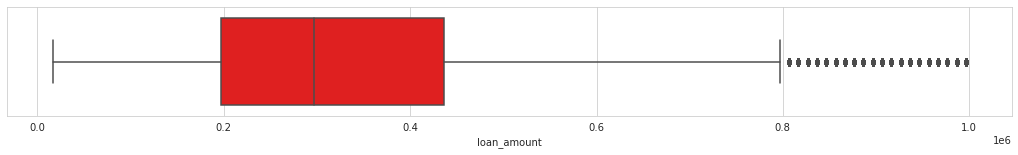

In [136]:
plt.figure(figsize=(18,2))
sns.set_style('whitegrid')
sns.boxplot(x='loan_amount',data=dflam1.toPandas(),color="red",orient="h")

In [137]:
dflam.select('loan_amount').where(dflam.loan_amount<1).count()

0

<AxesSubplot:xlabel='rate_of_interest', ylabel='Probability'>

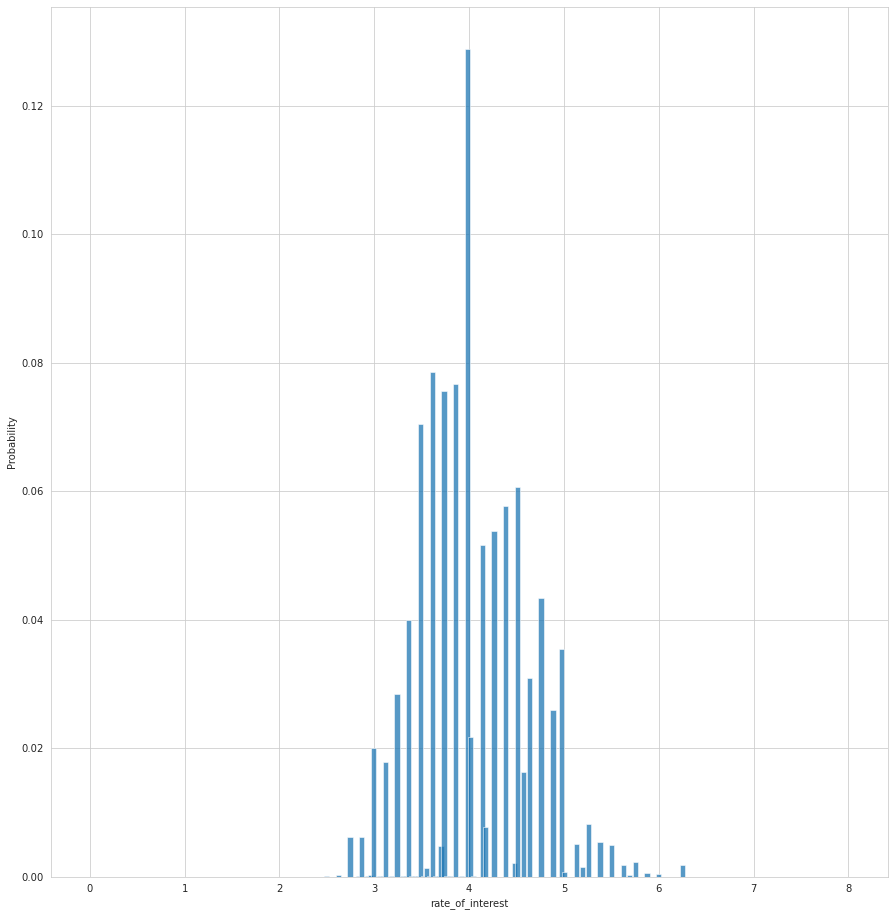

In [129]:
plt.figure(figsize=(15,16))
sns.histplot(x='rate_of_interest',data=pndasDF, stat="probability",shrink=1.8)       

Filtrer entre 2,5 et 6,5

<AxesSubplot:xlabel='rate_of_interest'>

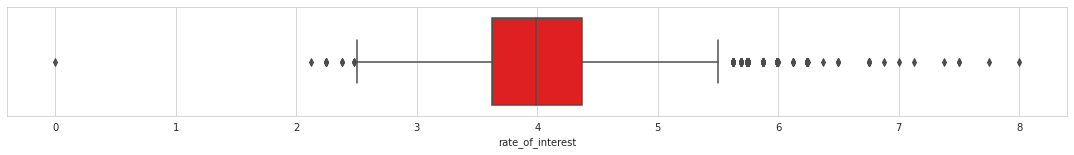

In [115]:
##Outliers
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='rate_of_interest',data=pndasDF,color="red",orient="h")

In [97]:
(df1.select('rate_of_interest').where(df1.rate_of_interest>5.5).count())+(df1.select('rate_of_interest').where(df1.rate_of_interest<2.5).count())

856


856 observations seront perdues si filtrage

<AxesSubplot:xlabel='Interest_rate_spread', ylabel='Probability'>

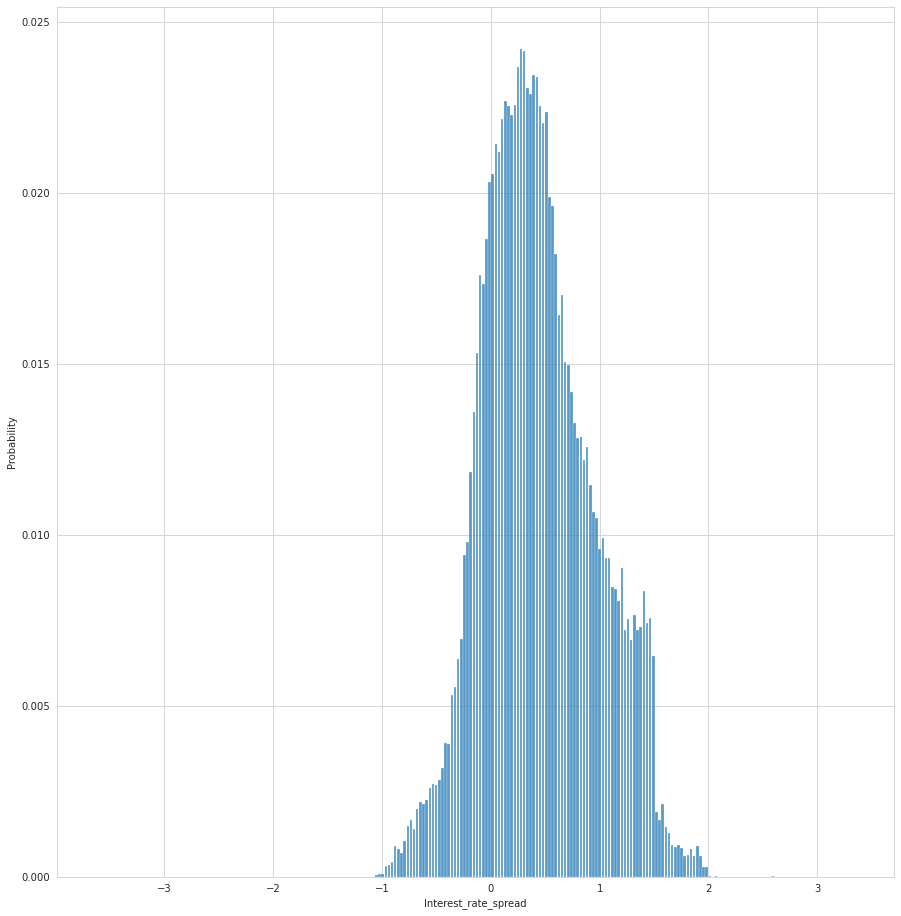

In [130]:
plt.figure(figsize=(15,16))
sns.histplot(x='Interest_rate_spread',data=pndasDF, stat="probability",shrink=.8)    

Filtrer entre -1 et 2 si filtrage

<AxesSubplot:xlabel='Interest_rate_spread'>

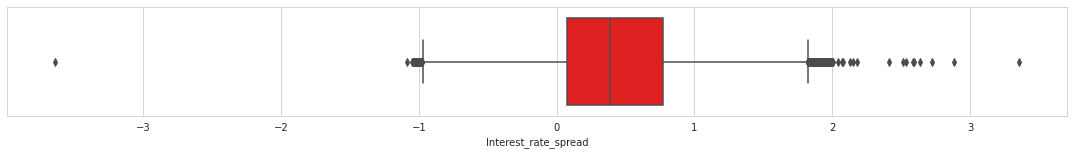

In [61]:
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='Interest_rate_spread',data=pndasDF,color="red",orient="h")

In [99]:
df1.select('Interest_rate_spread').where(df1.Interest_rate_spread<-1).count()+df1.select('Interest_rate_spread').where(df1.Interest_rate_spread>1.8).count()

489

Inforamtions en moins si filtrage

<AxesSubplot:xlabel='Upfront_charges', ylabel='Probability'>

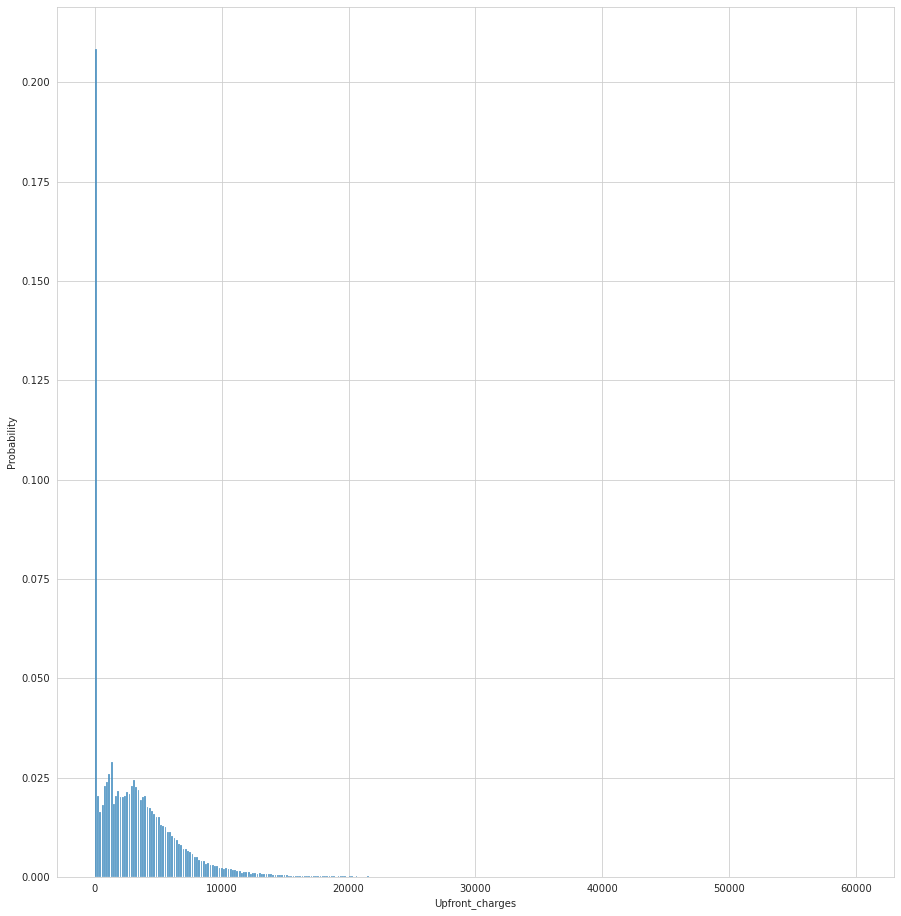

In [131]:
plt.figure(figsize=(15,16))
sns.histplot(x='Upfront_charges',data=pndasDF, stat="probability",shrink=.8)     

Filtrer <= 20000

<AxesSubplot:xlabel='Upfront_charges'>

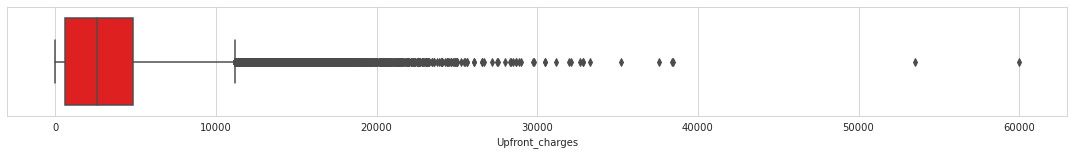

In [60]:
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='Upfront_charges',data=pndasDF,color="red",orient="h")

In [101]:
df1.select('Upfront_charges').where(df1.Upfront_charges>12000).count()

2225

Informations en moins si filtrage

<AxesSubplot:xlabel='term', ylabel='Probability'>

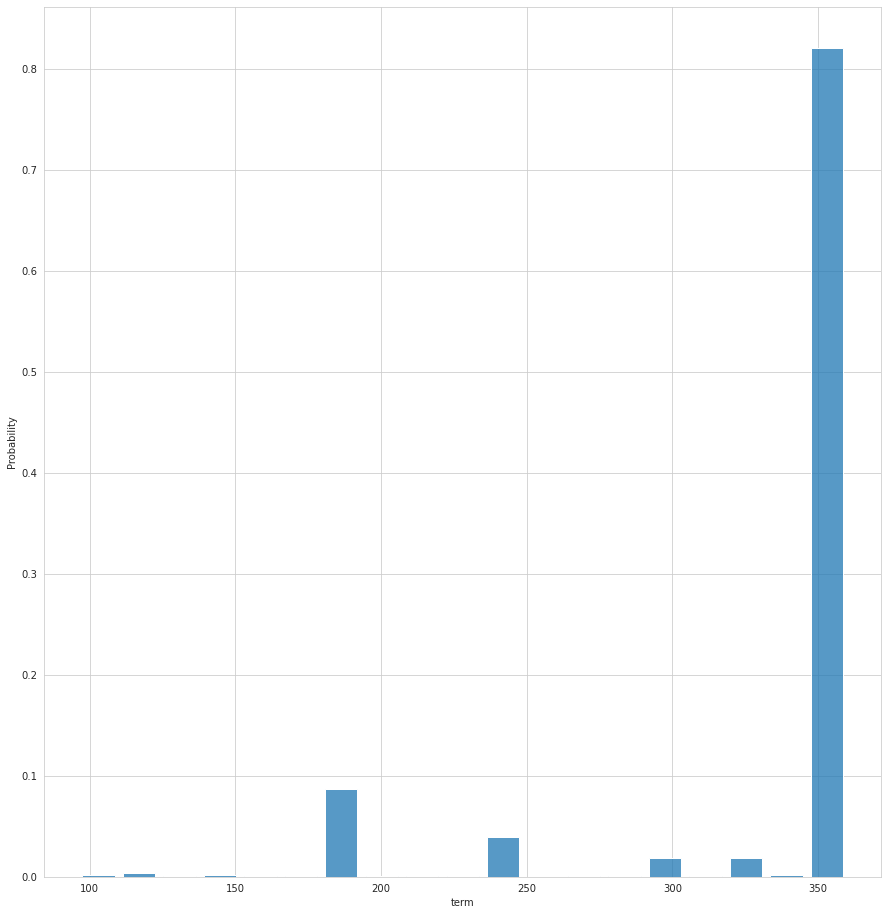

In [133]:
plt.figure(figsize=(15,16))
sns.histplot(x='term',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='term'>

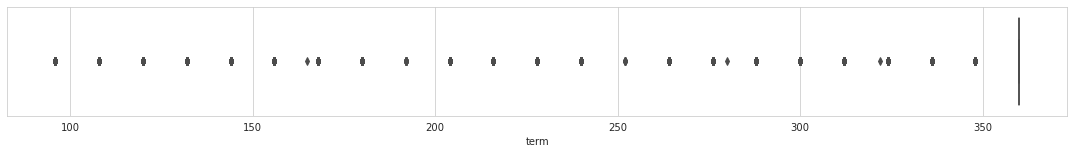

In [59]:
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='term',data=pndasDF,color="red",orient="h")

In [102]:
df1.select('term').where(df1.term<350).count()

26944

Informations en moins si filtrage

In [ ]:
sns.boxplot(x='property_value',data=pndasDF,color="red",orient="h")

<AxesSubplot:xlabel='Neg_ammortization', ylabel='Probability'>

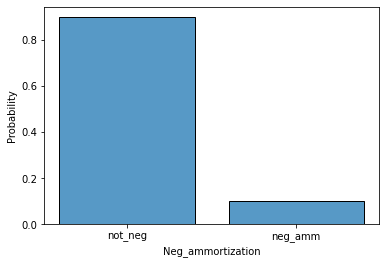

In [94]:
sns.histplot(x='Neg_ammortization',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='interest_only', ylabel='Probability'>

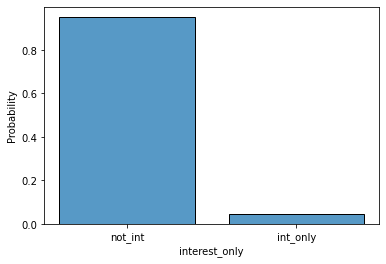

In [93]:
sns.histplot(x='interest_only',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='lump_sum_payment', ylabel='Probability'>

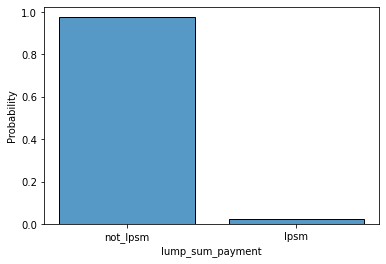

In [ ]:
sns.histplot(x='lump_sum_payment',data=pndasDF, stat="probability",shrink=.8)

Proba quasi nulle pour lpsm.

<AxesSubplot:xlabel='property_value', ylabel='Probability'>

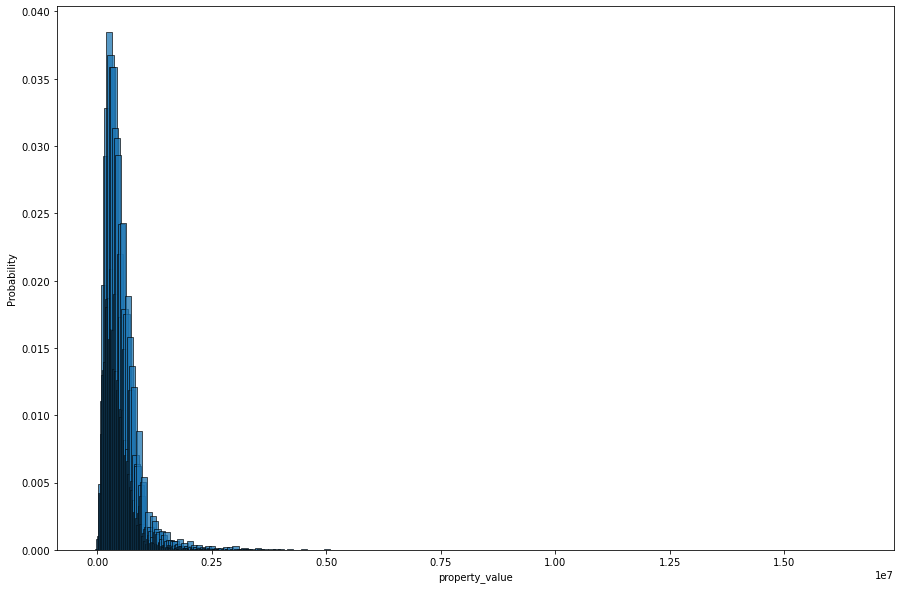

In [41]:
plt.figure(figsize=(15,10))
sns.histplot(x='property_value',data=pndasDF, stat="probability",shrink=9.8)

<AxesSubplot:xlabel='property_value'>

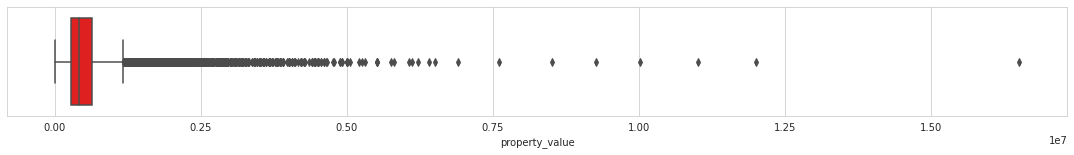

In [57]:
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='property_value',data=pndasDF,color="red",orient="h")

In [109]:
df1.select('property_value').where(df1.property_value>0.25).count() #la valeur 1e7 (exeptionnelle)

133572

En cas d'usage du filtrage: Filtrer entre 0 et 0,5

<AxesSubplot:xlabel='construction_type', ylabel='count'>

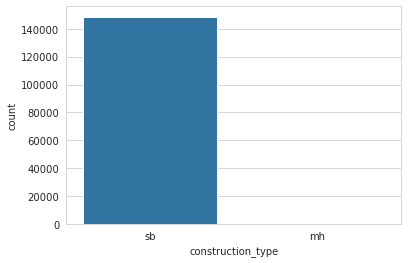

In [23]:
sns.countplot(x='construction_type',data=pndasDF)

Variable non informative sur la différence: ignorer

<AxesSubplot:xlabel='occupancy_type', ylabel='Probability'>

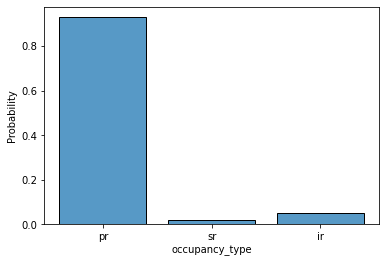

In [73]:
sns.histplot(x='occupancy_type',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='Secured_by', ylabel='Probability'>

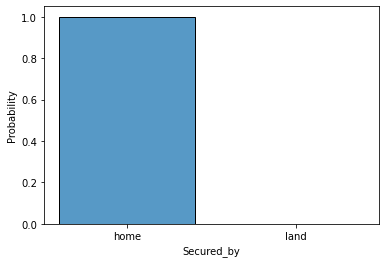

In [72]:
sns.histplot(x='Secured_by',data=pndasDF, stat="probability",shrink=.8)

Variable peu informative: ignorer

<AxesSubplot:xlabel='total_units', ylabel='Probability'>

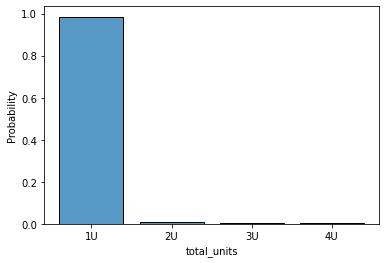

In [71]:
sns.histplot(x='total_units',data=pndasDF, stat="probability",shrink=.8)

Probabilité quasi nulle pour 2U 3U 4U. Variable à ignorer (apporte peu d'informations sur la différence)

<AxesSubplot:xlabel='income', ylabel='Probability'>

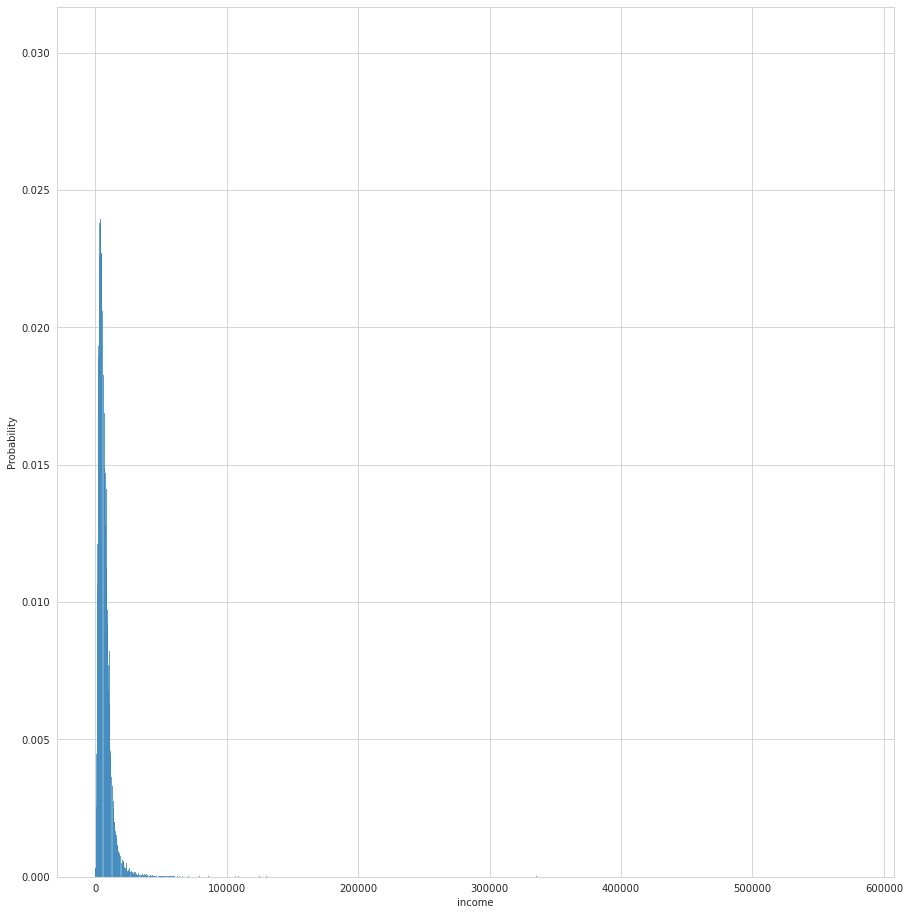

In [135]:
plt.figure(figsize=(15,16))
sns.histplot(x='income',data=pndasDF, stat="probability",shrink=1.8)

En cas d'usage du filtrage: filtrer <100000

<AxesSubplot:xlabel='income'>

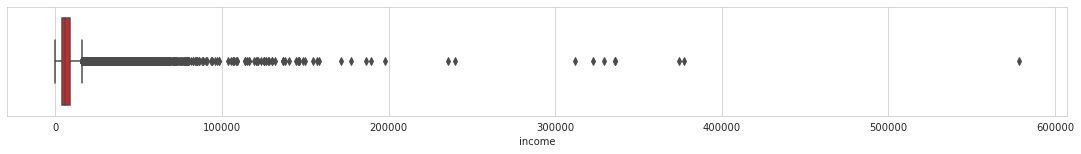

In [56]:
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='income',data=pndasDF,color="red",orient="h")

In [110]:
df1.select('income').where(df1.income>100000).count()

55

In [ ]:
Information en moins

<AxesSubplot:xlabel='credit_type', ylabel='Probability'>

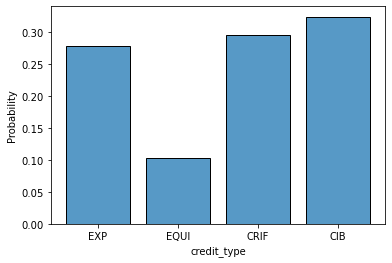

In [68]:
sns.histplot(x='credit_type',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='Credit_Score', ylabel='Probability'>

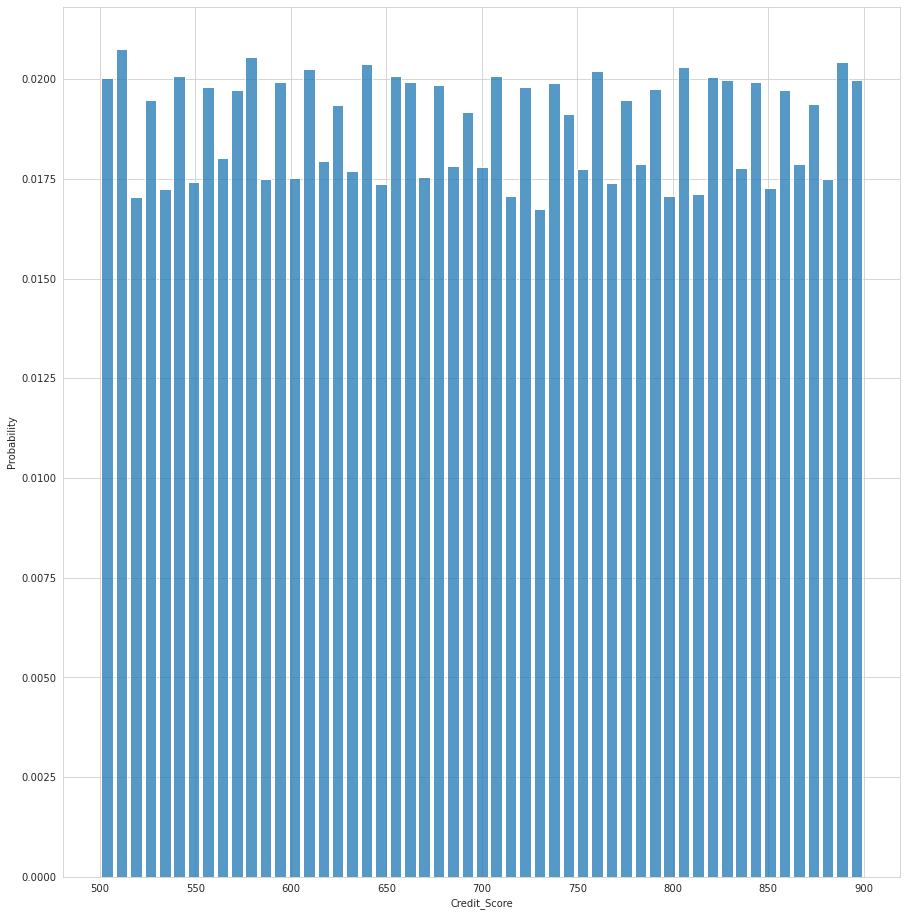

In [141]:
plt.figure(figsize=(15,16))
sns.histplot(x='Credit_Score',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='Credit_Score'>

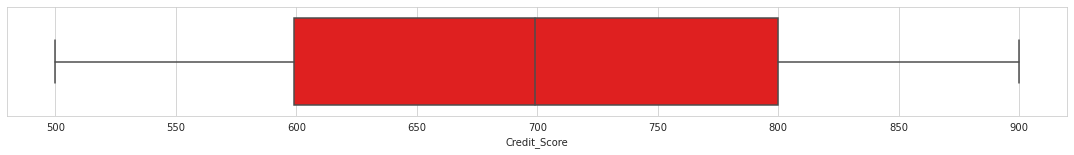

In [55]:
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='Credit_Score',data=pndasDF,color="red",orient="h")

<AxesSubplot:xlabel='co-applicant_credit_type', ylabel='Probability'>

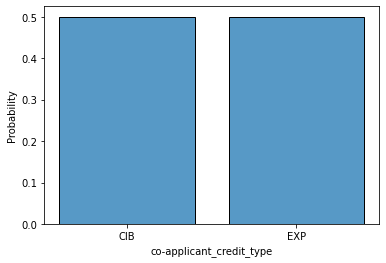

In [64]:
sns.histplot(x='co-applicant_credit_type',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='age', ylabel='Probability'>

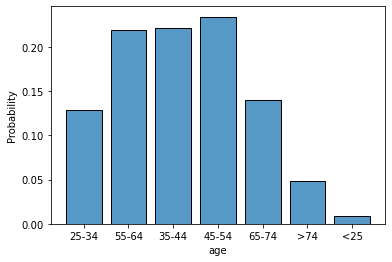

In [61]:
#plt.figure(figsize=(15,16))
sns.histplot(x='age',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='submission_of_application', ylabel='Probability'>

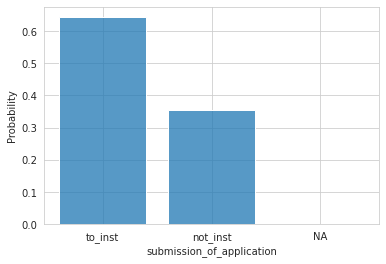

In [137]:
sns.histplot(x='submission_of_application',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='LTV', ylabel='Probability'>

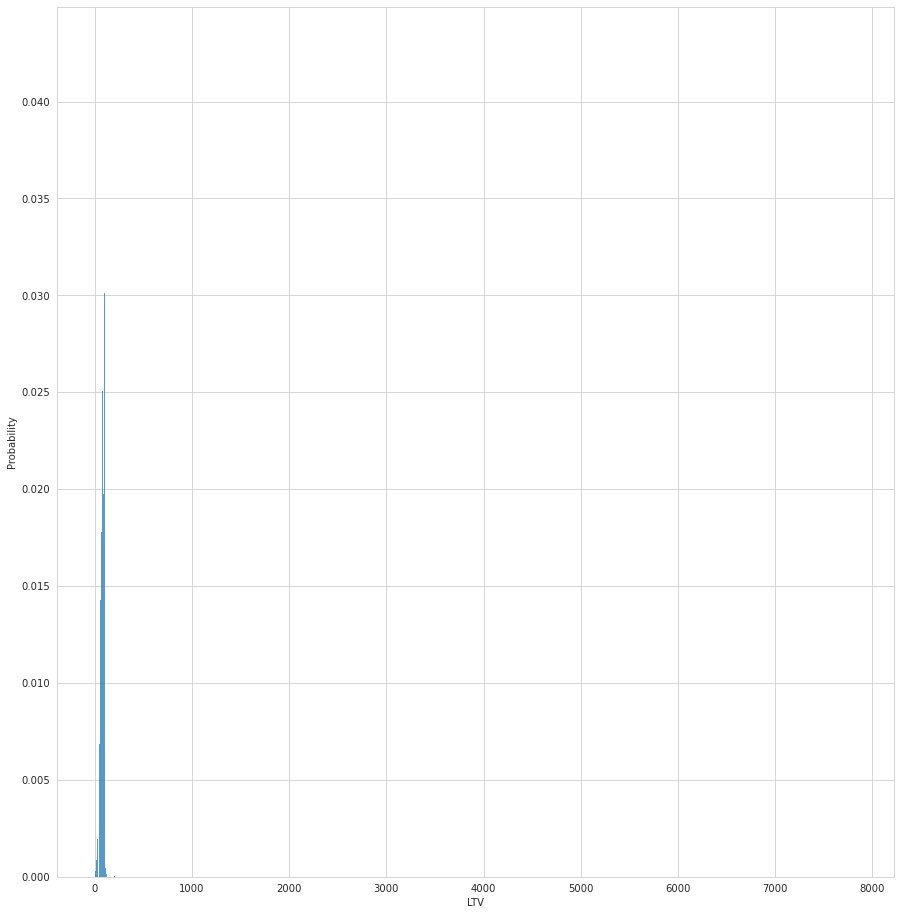

In [142]:
plt.figure(figsize=(15,16))
sns.histplot(x='LTV',data=pndasDF, stat="probability",shrink=.8)  

En cas d'usage filtrer voir quartile pour le seuil vers 100

<AxesSubplot:xlabel='LTV'>

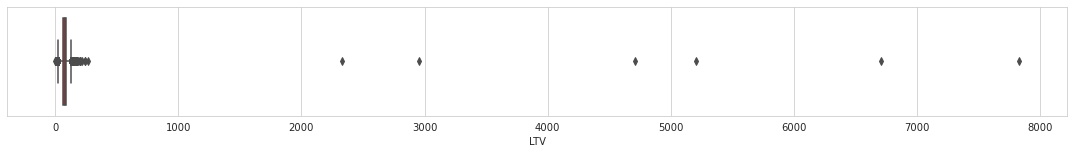

In [54]:
plt.figure(figsize=(19,2))
sns.set_style('whitegrid')
sns.boxplot(x='LTV',data=pndasDF,color="red",orient="h")

In [113]:
df1.select('LTV').where(df1.LTV>100).count()

1799

Informations en moins si filtrage d'outliers. A ce nombre on peut se demander si ce sont des outliers

<AxesSubplot:xlabel='Gender', ylabel='Probability'>

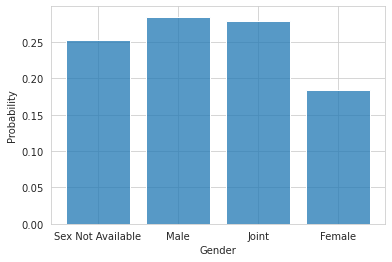

In [118]:
sns.histplot(x='Gender',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='Security_Type', ylabel='Probability'>

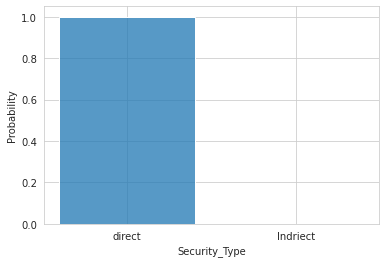

In [139]:
sns.histplot(x='Security_Type',data=pndasDF, stat="probability",shrink=.8)

Peu informatif ne pas retenir

<AxesSubplot:xlabel='Status', ylabel='Probability'>

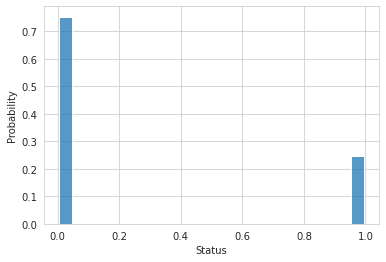

In [143]:
sns.histplot(x='Status',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='loan_limit', ylabel='Probability'>

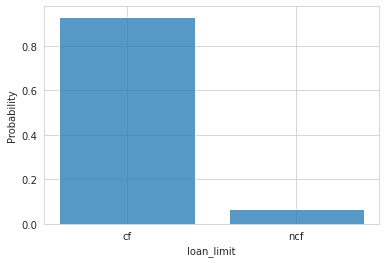

In [11]:
#plt.figure(figsize=(15,6))
sns.histplot(x='loan_limit',data=pndasDF, stat="probability",shrink=.8)

<AxesSubplot:xlabel='dtir1'>

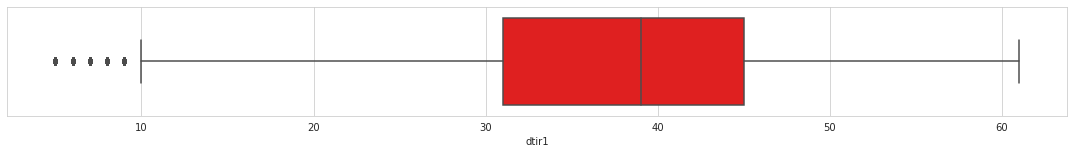

### *******Résumé et décisons (sélection) à partir de la distribution des variables*******
            - Notre choix d'ignorer une variable ici est basé sur la probabilité. Une variable binaire avec une probabilité quasi nulle de réalisation d'une certaine modalité ne retient pas notre attention selon notre approche. Nous estimons qu'il faut un certain nombre de réalisations pour un meilleur apprentissage des algos.

- age pas de problème d’ouliers
- dtir1 concernée par le problème d’outliers (près de 2013)
- Credit_type pas concerné par le problème d’outliers
- Region peu concernée
- loan_purpose peu concernée
- Approv-in_adv peu concernée
- loan_type peu concernée
- Credit_Worthiness peu concernée
- *** open_credit à ignorer ***
- Business_or_commercial peu concernée
- loan_amount conernée (type double)
- rate_of_interest concerné (856)
- interest_rate_spread concernée (489)
- Upfront_charges concernée (2225)
- Term concernée (26944) mais à ne pas nettoyer
- Neg_ammortization peu concernée
- interest_only concernée
- *** lump_sum_payment concernée
- property_value concernée (type double)
- *** construction_type à ignorer ***
- occupancy_type concernée
- *** Secured_by à ignorer***
- *** total_units à ignonrer ***
- income concernée (55)
- Credit_score pas concernée
- *co-applicant_credit_type pas concernée
- *Submission_of_application pas concerné mais remplacer NA par NULL
- LTV concernée (1799)
- *** Security_type à ignorer ***
- Gender pas concernée
- loan_limit concernée
- status



***BASE DE DONNEES REDUITE AVANT CORRELATIONS***

In [7]:
df2=df1.drop('Security_Type','total_units','Secured_by','construction_type','lump_sum_payment','open_credit') 
pndDF = df2.toPandas()

In [139]:
#df1.columns

***Corrélation***

          ****Rappelons que les corrélations sont sensibles aux outliers tout comme les moyennes et variances

- Correlation gérérale (base avant reduction) valeurs numériques

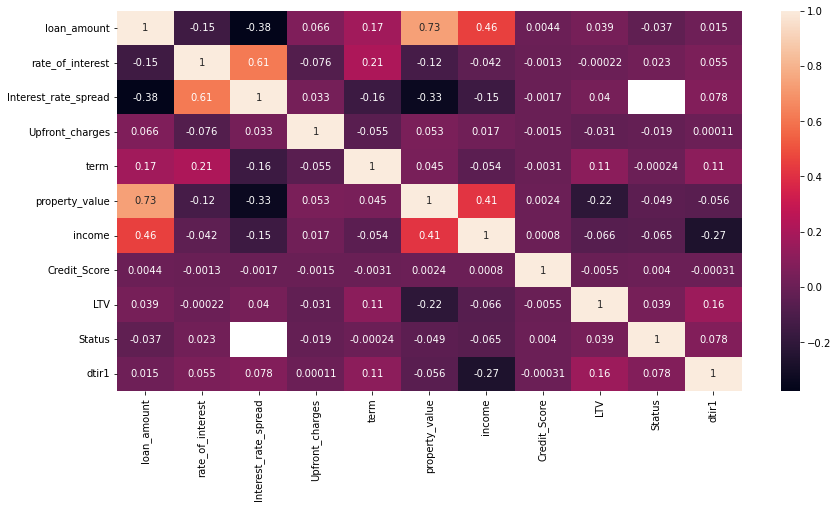

In [12]:
## Corrélation: heat map (valeurs numériques uniquement)
plt.figure(figsize=(14,7))
cor = pndaDF.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [ ]:
corrDF = pndasDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corrDF
plt.figure(figsize=(25,15))
sns.heatmap(corrDF, annot=True)
plt.show()


In [ ]:
#df1=datadf.drop('ID','year') 

In [ ]:
#df1.show()

In [13]:
pndaDF = df1.toPandas()

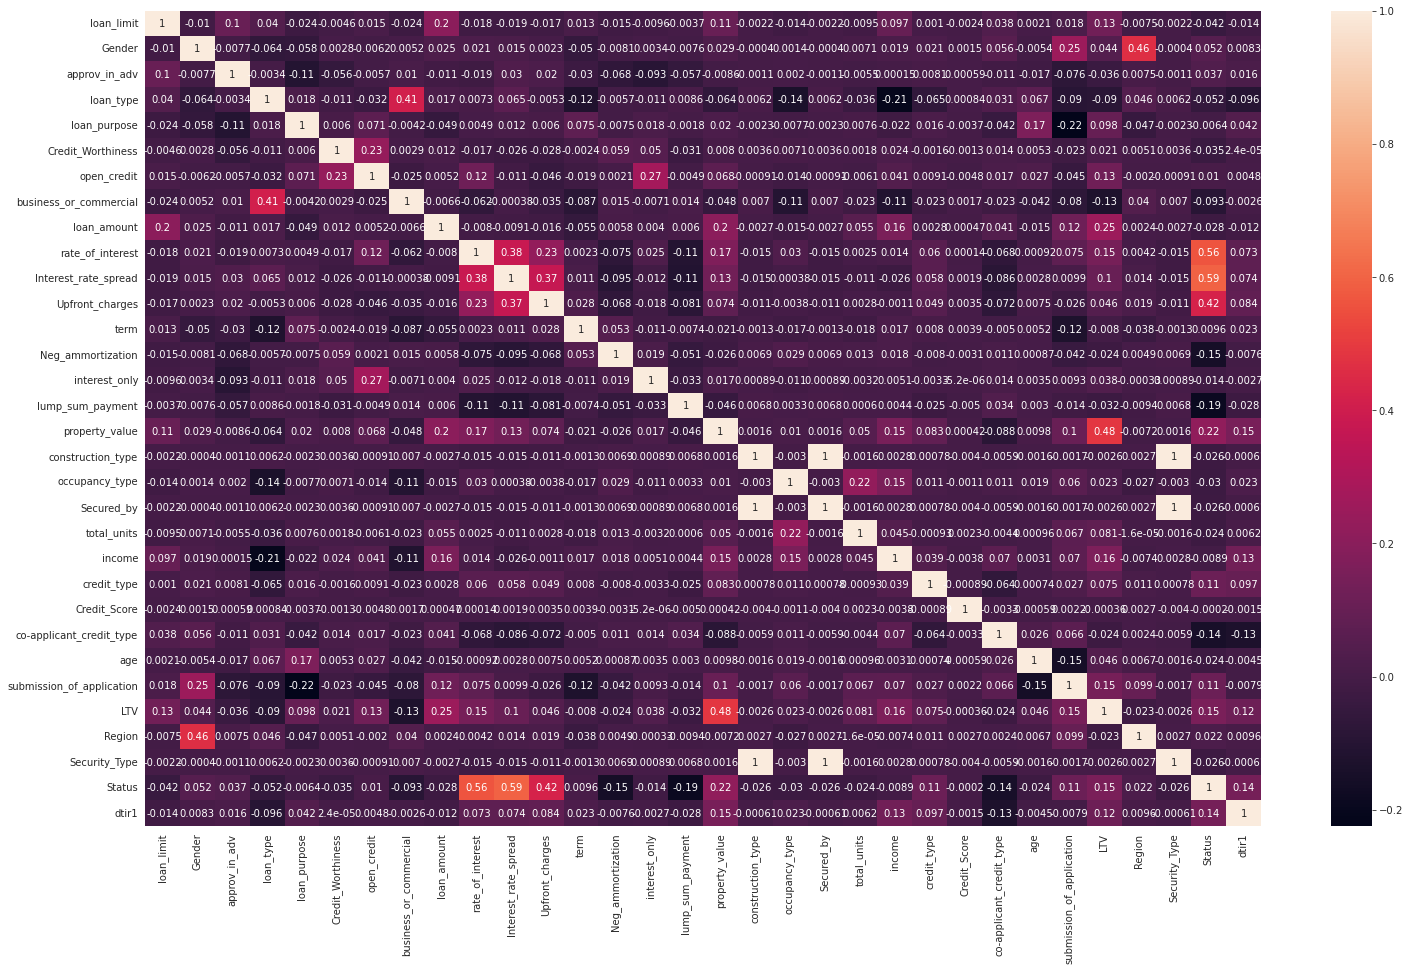

In [174]:
corrDF1 = pndaDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corrDF1
plt.figure(figsize=(25,15))
sns.heatmap(corrDF1, annot=True)
plt.show()

**Aléger la matrice de corrélation**

Mettre en évidence les corrélations d'un certain intervalle 

In [10]:
import numpy as np

<AxesSubplot:>

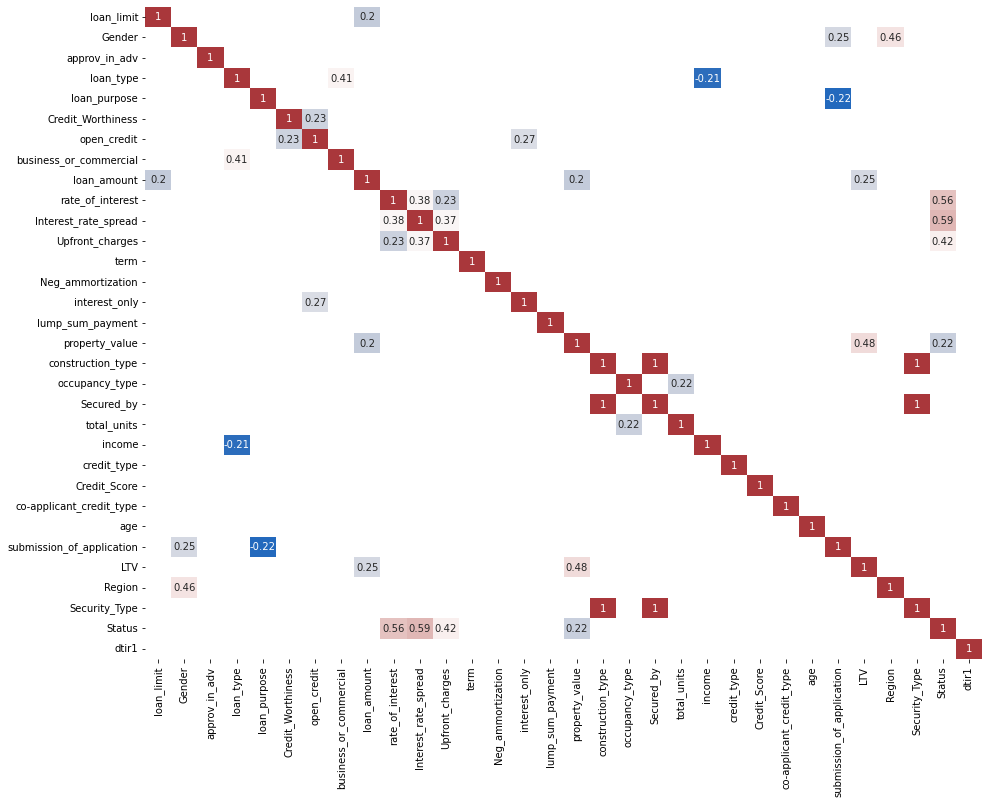

In [50]:
datacor=(pndaDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)).round(3)
corrA = np.squeeze(np.asarray(datacor))
mask = np.zeros(pndaDF.apply(lambda x : pd.factorize(x)[0]).corr().shape)
for i in range(32):
    for j in range(32):
        if -0.2<corrA[i][j]<0.2:
            mask[i][j]=1
plt.figure(figsize=(15,12))
sns.heatmap(datacor, annot=True,mask= mask, cbar=False, cmap='vlag')
#savefig("my_corr_matrix.pdf")

***Voir le nombre de valeurs manquantes par variable***

In [11]:
from pyspark.sql.functions import isnan, when, count, col
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show(vertical=True)



-RECORD 0--------------------------
 loan_limit                | 3344  
 Gender                    | 0     
 approv_in_adv             | 908   
 loan_type                 | 0     
 loan_purpose              | 134   
 Credit_Worthiness         | 0     
 open_credit               | 0     
 business_or_commercial    | 0     
 loan_amount               | 0     
 rate_of_interest          | 36439 
 Interest_rate_spread      | 36639 
 Upfront_charges           | 39642 
 term                      | 41    
 Neg_ammortization         | 121   
 interest_only             | 0     
 lump_sum_payment          | 0     
 property_value            | 15098 
 construction_type         | 0     
 occupancy_type            | 0     
 Secured_by                | 0     
 total_units               | 0     
 income                    | 9150  
 credit_type               | 0     
 Credit_Score              | 0     
 co-applicant_credit_type  | 0     
 age                       | 200   
 submission_of_application |

In [ ]:
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show(vertical=True)

Nous constatons que les valeurs 

***Pearson correlation coefficient and p-value for testing non-correlation.***

In [87]:
from scipy.stats import pearsonr
rho = pndaDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
pval = pndaDF.apply(lambda x : pd.factorize(x)[0]).corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
loan_limit,1.0***,-0.01***,0.1***,0.04***,-0.02***,-0.0*,0.01***,-0.02***,0.2***,-0.02***,...,0.0,-0.0,0.04***,0.0,0.02***,0.13***,-0.01***,-0.0,-0.04***,-0.01***
Gender,-0.01***,1.0***,-0.01***,-0.06***,-0.06***,0.0,-0.01**,0.01**,0.02***,0.02***,...,0.02***,0.0,0.06***,-0.01**,0.25***,0.04***,0.46***,-0.0,0.05***,0.01***
approv_in_adv,0.1***,-0.01***,1.0***,-0.0,-0.11***,-0.06***,-0.01**,0.01***,-0.01***,-0.02***,...,0.01***,0.0,-0.01***,-0.02***,-0.08***,-0.04***,0.01***,-0.0,0.04***,0.02***
loan_type,0.04***,-0.06***,-0.0,1.0***,0.02***,-0.01***,-0.03***,0.41***,0.02***,0.01***,...,-0.07***,0.0,0.03***,0.07***,-0.09***,-0.09***,0.05***,0.01**,-0.05***,-0.1***
loan_purpose,-0.02***,-0.06***,-0.11***,0.02***,1.0***,0.01**,0.07***,-0.0,-0.05***,0.0*,...,0.02***,-0.0,-0.04***,0.17***,-0.22***,0.1***,-0.05***,-0.0,-0.01**,0.04***
Credit_Worthiness,-0.0*,0.0,-0.06***,-0.01***,0.01**,1.0***,0.23***,0.0,0.01***,-0.02***,...,-0.0,-0.0,0.01***,0.01**,-0.02***,0.02***,0.01*,0.0,-0.03***,0.0
open_credit,0.01***,-0.01**,-0.01**,-0.03***,0.07***,0.23***,1.0***,-0.02***,0.01**,0.12***,...,0.01***,-0.0*,0.02***,0.03***,-0.05***,0.13***,-0.0,-0.0,0.01***,0.0*
business_or_commercial,-0.02***,0.01**,0.01***,0.41***,-0.0,0.0,-0.02***,1.0***,-0.01**,-0.06***,...,-0.02***,0.0,-0.02***,-0.04***,-0.08***,-0.13***,0.04***,0.01***,-0.09***,-0.0
loan_amount,0.2***,0.02***,-0.01***,0.02***,-0.05***,0.01***,0.01**,-0.01**,1.0***,-0.01***,...,0.0,0.0,0.04***,-0.02***,0.12***,0.25***,0.0,-0.0,-0.03***,-0.01***
rate_of_interest,-0.02***,0.02***,-0.02***,0.01***,0.0*,-0.02***,0.12***,-0.06***,-0.01***,1.0***,...,0.06***,0.0,-0.07***,-0.0,0.08***,0.15***,0.0,-0.01***,0.56***,0.07***


Tester la signification des correlations

In [15]:
def corr_sig(dtfr=None):
    p_matrix = np.zeros(shape=(dtfr.shape[1],dtfr.shape[1]))
    for col in dtfr.columns:
        for col2 in dtfr.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(dtfr[col],dtfr[col2])
            p_matrix[dtfr.columns.to_list().index(col),dtfr.columns.to_list().index(col2)] = p
    return p_matrix




In [16]:
def plot_cor_matricorr(corr, mask=None):
    f, ax = plt.subplots(figsize=(30, 15))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', cbar_kws={'orientation': 'horizontal'})




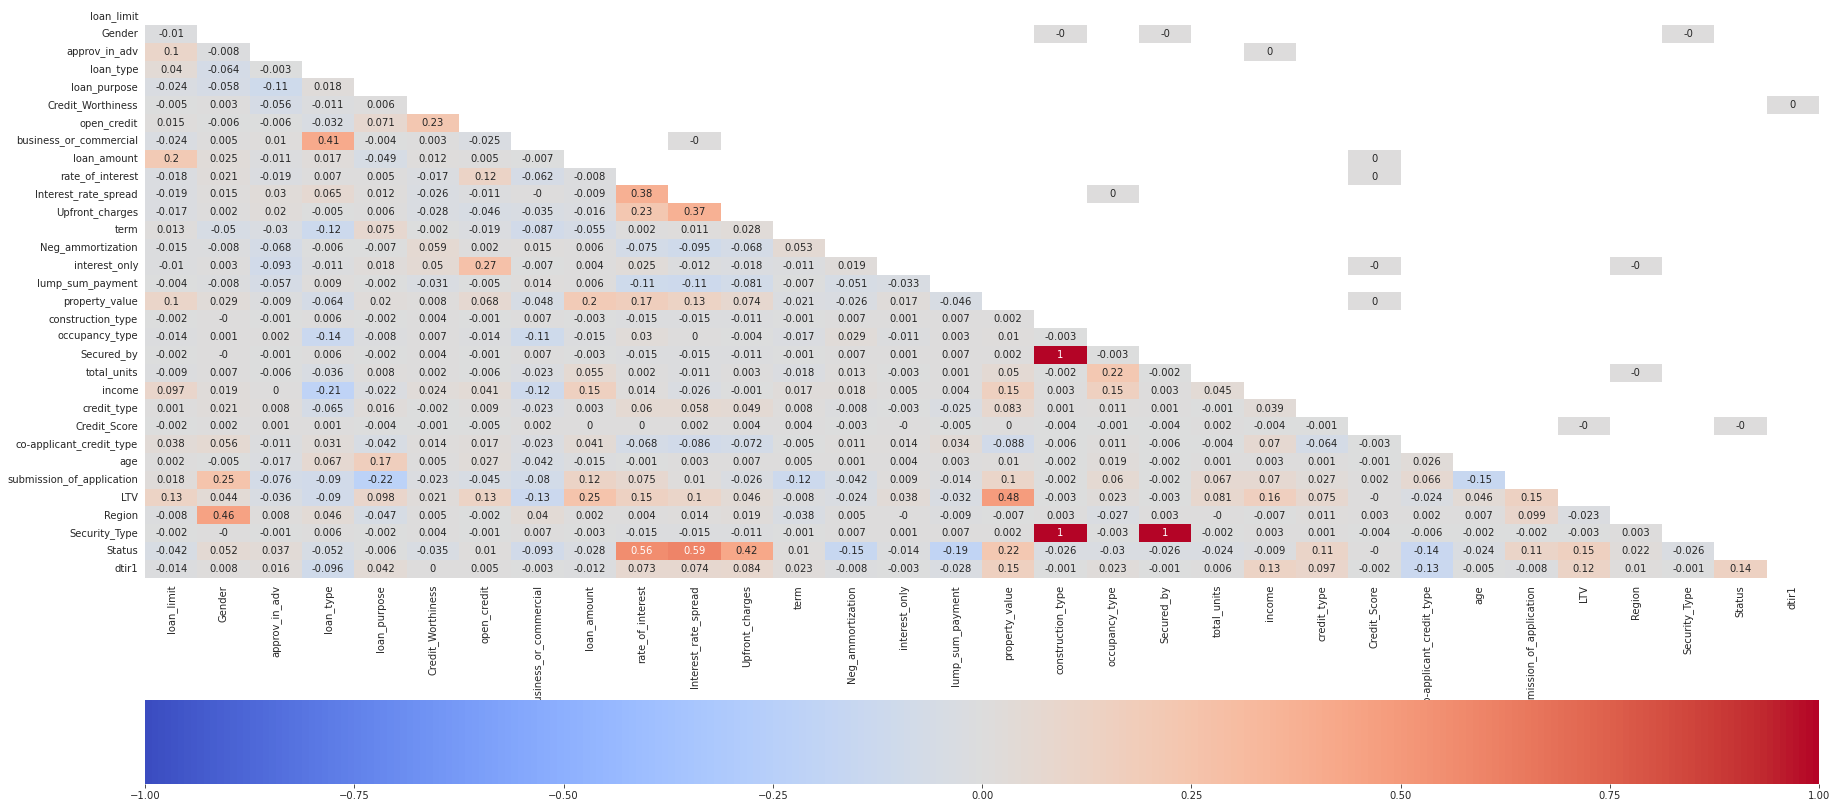

In [19]:
corr = (pndaDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)).round(3)
mask = np.triu(corr)
plot_cor_matricorr(corr,mask)
plt.show()



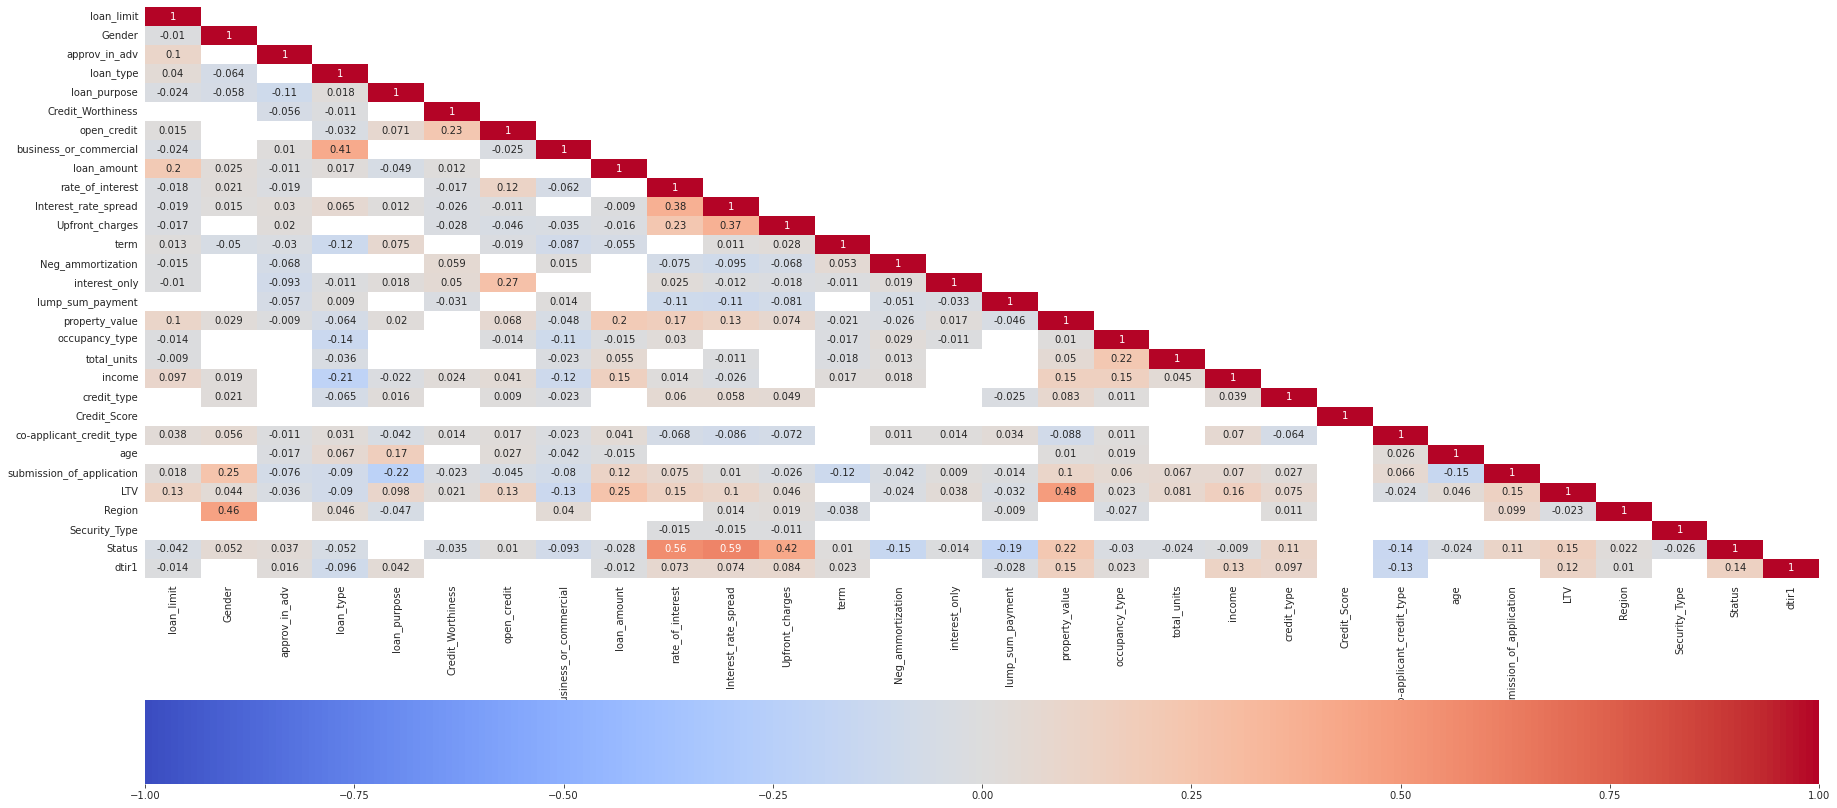

In [160]:

# Plotting with significance filter
from scipy import stats
p_values = corr_sig(pndaDF.apply(lambda x : pd.factorize(x)[0]))                     # get p-Value
mask = np.invert(np.tril(p_values<0.001))    # mask - only get significant corr
plot_cor_matricorr(corr,mask)

- Corrélation avec base réduite (df2 ou pndDF)

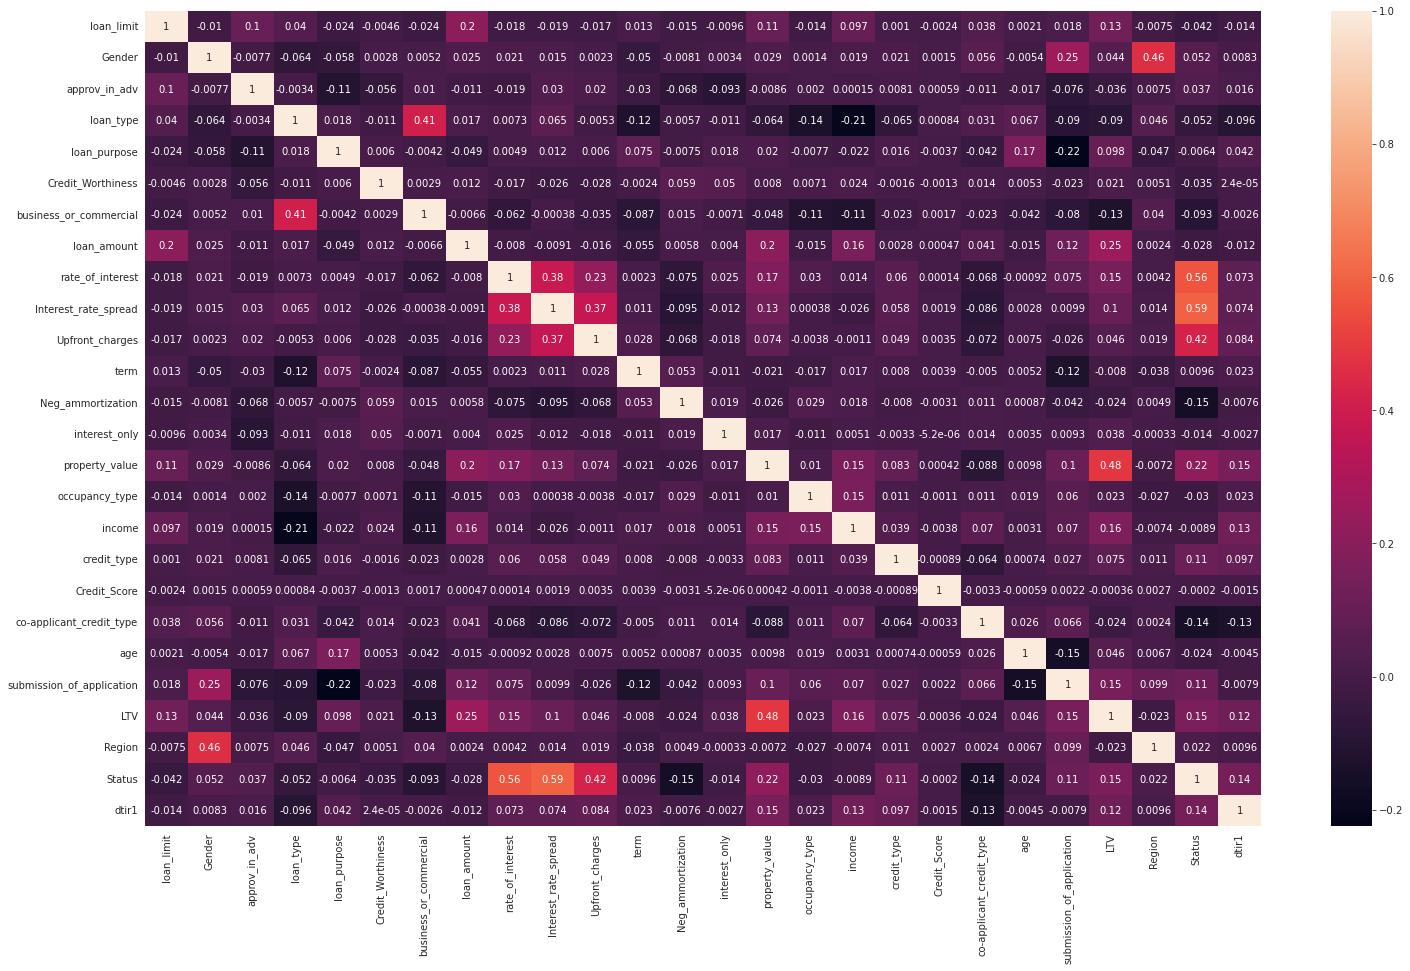

In [144]:
corrDF2 = pndDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corrDF2
plt.figure(figsize=(25,15))
sns.heatmap(corrDF2, annot=True)
plt.show()

**Aléger la matrice de correlation**

In [148]:
from scipy.stats import pearsonr
rho2 = pndDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
pval = pndDF.apply(lambda x : pd.factorize(x)[0]).corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho2.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho2.round(2).astype(str) + p

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Status,dtir1
loan_limit,1.0***,-0.01***,0.1***,0.04***,-0.02***,-0.0*,-0.02***,0.2***,-0.02***,-0.02***,...,0.1***,0.0,-0.0,0.04***,0.0,0.02***,0.13***,-0.01***,-0.04***,-0.01***
Gender,-0.01***,1.0***,-0.01***,-0.06***,-0.06***,0.0,0.01**,0.02***,0.02***,0.01***,...,0.02***,0.02***,0.0,0.06***,-0.01**,0.25***,0.04***,0.46***,0.05***,0.01***
approv_in_adv,0.1***,-0.01***,1.0***,-0.0,-0.11***,-0.06***,0.01***,-0.01***,-0.02***,0.03***,...,0.0,0.01***,0.0,-0.01***,-0.02***,-0.08***,-0.04***,0.01***,0.04***,0.02***
loan_type,0.04***,-0.06***,-0.0,1.0***,0.02***,-0.01***,0.41***,0.02***,0.01***,0.06***,...,-0.21***,-0.07***,0.0,0.03***,0.07***,-0.09***,-0.09***,0.05***,-0.05***,-0.1***
loan_purpose,-0.02***,-0.06***,-0.11***,0.02***,1.0***,0.01**,-0.0,-0.05***,0.0*,0.01***,...,-0.02***,0.02***,-0.0,-0.04***,0.17***,-0.22***,0.1***,-0.05***,-0.01**,0.04***
Credit_Worthiness,-0.0*,0.0,-0.06***,-0.01***,0.01**,1.0***,0.0,0.01***,-0.02***,-0.03***,...,0.02***,-0.0,-0.0,0.01***,0.01**,-0.02***,0.02***,0.01*,-0.03***,0.0
business_or_commercial,-0.02***,0.01**,0.01***,0.41***,-0.0,0.0,1.0***,-0.01**,-0.06***,-0.0,...,-0.11***,-0.02***,0.0,-0.02***,-0.04***,-0.08***,-0.13***,0.04***,-0.09***,-0.0
loan_amount,0.2***,0.02***,-0.01***,0.02***,-0.05***,0.01***,-0.01**,1.0***,-0.01***,-0.01***,...,0.16***,0.0,0.0,0.04***,-0.02***,0.12***,0.25***,0.0,-0.03***,-0.01***
rate_of_interest,-0.02***,0.02***,-0.02***,0.01***,0.0*,-0.02***,-0.06***,-0.01***,1.0***,0.38***,...,0.01***,0.06***,0.0,-0.07***,-0.0,0.08***,0.15***,0.0,0.56***,0.07***
Interest_rate_spread,-0.02***,0.01***,0.03***,0.06***,0.01***,-0.03***,-0.0,-0.01***,0.38***,1.0***,...,-0.03***,0.06***,0.0,-0.09***,0.0,0.01***,0.1***,0.01***,0.59***,0.07***


Les variables sont liées les unes aux autres de manière significative. 
- Soustraire une variable de l'étude a moins d'effet car l'information sur sa situation est plus ou moins indiquée par d'autres. Nous allons donc réduire davantage nos variables. 
- Nous conssidérons que lorsque deux variables sont liées entre elles (exception faite de la variable status) avec un lien d'au moins 0.2 en valeur absolue, une d'entre elle est considérable dans le modèle et non les deux en même temps. 
- Le choix de garder  repose aussi sur le fait d'avoir le moins de valeurs manquantes ou le fait d'avoir moins de problème d'outliers. 

In [164]:
def corr_sig(dtfr=None):
    p_matrix = np.zeros(shape=(dtfr.shape[1],dtfr.shape[1]))
    for col in dtfr.columns:
        for col2 in dtfr.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(dtfr[col],dtfr[col2])
            p_matrix[dtfr.columns.to_list().index(col),dtfr.columns.to_list().index(col2)] = p
    return p_matrix




In [166]:
def plot_cor_matricorr(corrB, mask=None):
    f, ax = plt.subplots(figsize=(30, 15))
    sns.heatmap(corrB, ax=ax,
                mask=mask,
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', cbar_kws={'orientation': 'horizontal'})




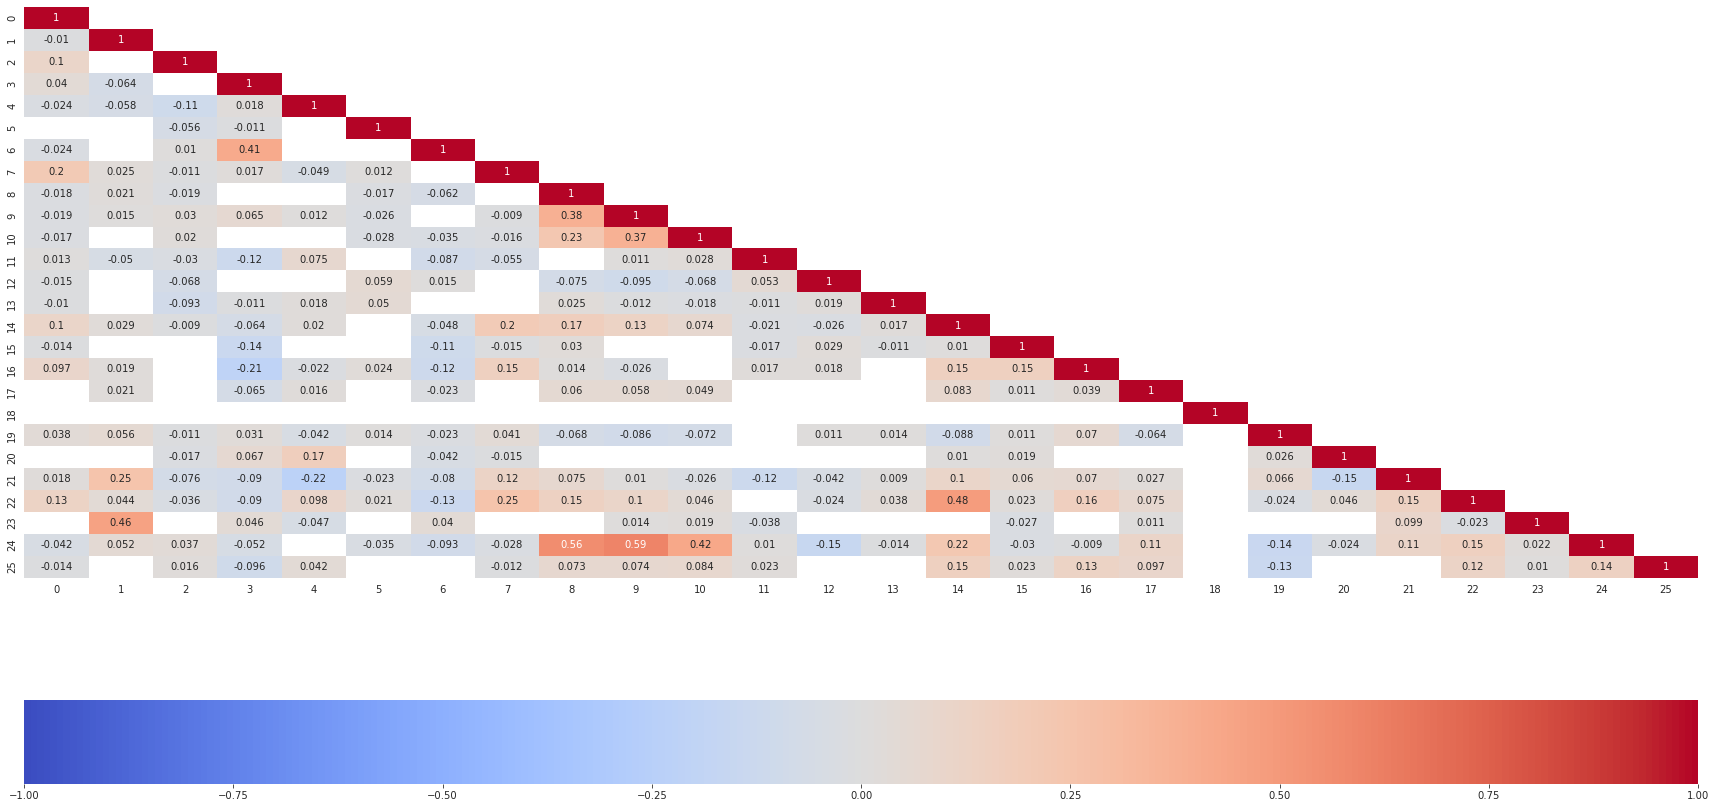

In [168]:
from scipy import stats
p_values = corr_sig(pndDF.apply(lambda x : pd.factorize(x)[0]))                     # get p-Value
mask = np.invert(np.tril(p_values<0.001))    # mask - only get significant corr
plot_cor_matricorr(corrB,mask)

<AxesSubplot:>

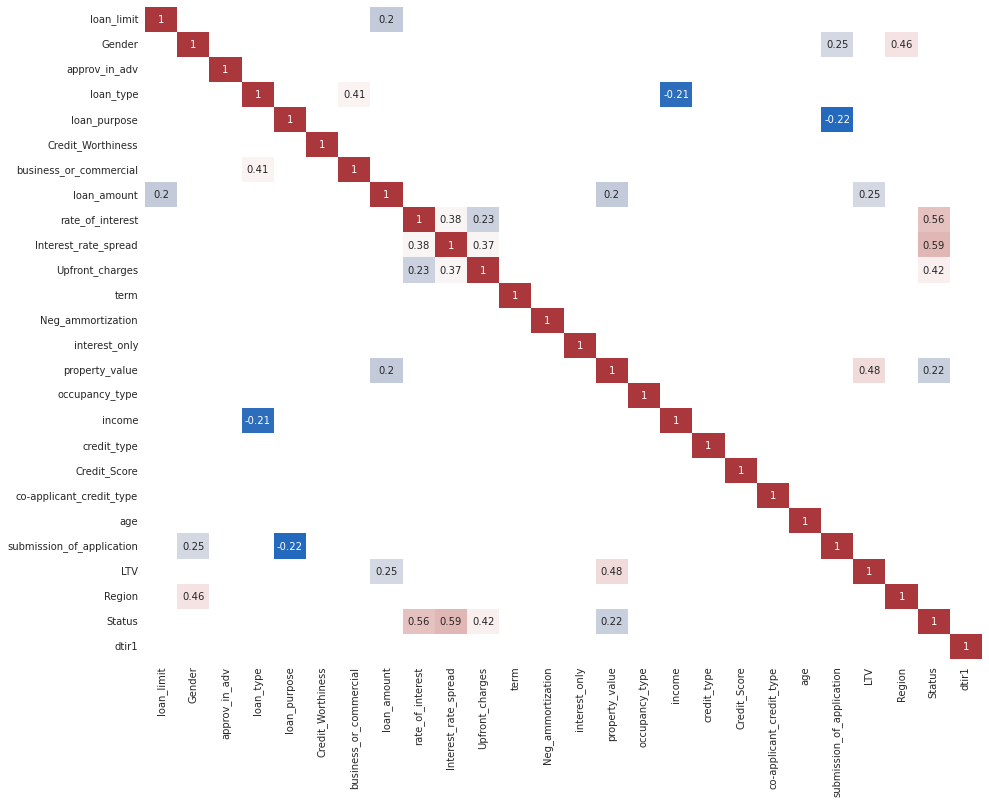

In [163]:
datacor2=(pndDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)).round(3)
corrB = np.squeeze(np.asarray(datacor2))
mask = np.zeros(pndDF.apply(lambda x : pd.factorize(x)[0]).corr().shape)
for i in range(26):
    for j in range(26):
        if -0.2<corrB[i][j]<0.2:
            mask[i][j]=1
plt.figure(figsize=(15,12))
sns.heatmap(datacor2, annot=True,mask= mask, cbar=False, cmap='vlag')
#savefig("my_corr_matrix.pdf")

#### ****** RESUME SUR LE CHOIX DES VARIABLES ******####

- Plusieurs possibilités
    - Garder genre et laisser région et submission of application
    - Choisir entre rate_of_interest, interest_rate_spread et Upfront_charges 
    - Garder loan_amount et laisser LTV et property value
    - Garder loan_type et laisser income
    - choisir entre business_or_commercial et loan_type : loan type
    - Garder loan_amount et laisser loan_limit

- Notre choix
    - **laisser Region** 
    - **laisser Interest_rate_spread**
    - **laisser Upfront_charges** 
    - **laisser submission_of_application**
    - **laisser  property_value**
    - **laisser LTV** 
    - **laisser income**
    - **laisser business_or_commercial**
    - **laisser loan_limit** 

***BASE DE DONNEES REDUITE APRES ANALYSE DES CORRELATIONS***

In [12]:
df3=df2.drop('Region','loan_limit','business_or_commercial','Interest_rate_spread',
             'Upfront_charges','income','LTV','submission_of_application','property_value') 
pdDF = df3.toPandas()

In [172]:
#df2.columns

***Les valeurs manquantes pour la nouvelle base de données***

- Plusieurs démarches existent pour gérer les nas
-  Un modèle sans na est plus robuste mais supprimer tous les nas a un coût en matière de perte d'infos. Cependant, nous estimons que nous avons assez d'info pour essayer cette strétégie

In [226]:
#from pyspark.sql.functions import isnan, when, count, col
df3.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df3.columns]).show(vertical=True)

-RECORD 0-------------------------
 Gender                   | 0     
 approv_in_adv            | 908   
 loan_type                | 0     
 loan_purpose             | 134   
 Credit_Worthiness        | 0     
 loan_amount              | 0     
 rate_of_interest         | 36439 
 term                     | 41    
 Neg_ammortization        | 121   
 interest_only            | 0     
 occupancy_type           | 0     
 credit_type              | 0     
 Credit_Score             | 0     
 co-applicant_credit_type | 0     
 age                      | 200   
 Status                   | 0     
 dtir1                    | 24121 



Filtrer sur rate_of_interest pour éviter les données manquantes : 
    elles sont nombreuses et leur remplacement par la moyenne par exemple peut éventuellement affecter le modèle
    #https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

In [13]:
df3f=df3.filter(col("rate_of_interest").isNotNull())

In [228]:
df3f.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df3f.columns]).show(vertical=True)

-RECORD 0------------------------
 Gender                   | 0    
 approv_in_adv            | 667  
 loan_type                | 0    
 loan_purpose             | 107  
 Credit_Worthiness        | 0    
 loan_amount              | 0    
 rate_of_interest         | 0    
 term                     | 26   
 Neg_ammortization        | 89   
 interest_only            | 0    
 occupancy_type           | 0    
 credit_type              | 0    
 Credit_Score             | 0    
 co-applicant_credit_type | 0    
 age                      | 200  
 Status                   | 0    
 dtir1                    | 8011 



In [606]:
df3f.toPandas().shape

(112231, 17)

In [608]:
df3f.groupBy("Status","rate_of_interest").count().show() 

+------+------+
|Status| count|
+------+------+
|     1| 36639|
|     0|112031|
+------+------+



In [996]:
df3f.groupBy("Status","rate_of_interest").count().show() 

+------+----------------+-----+
|Status|rate_of_interest|count|
+------+----------------+-----+
|     0|            6.24|  214|
|     1|           4.375|   24|
|     0|            2.25|    4|
|     0|            7.75|    1|
|     0|           6.875|    1|
|     1|           4.875|   14|
|     0|           4.625| 3474|
|     0|             3.1|   13|
|     0|            4.18|  873|
|     0|            3.15|    6|
|     0|            3.75| 8447|
|     0|            3.95|    3|
|     0|           3.575|   15|
|     0|            2.85|   10|
|     0|             7.5|    2|
|     1|            5.25|    4|
|     0|           4.025|    2|
|     0|            3.05|    8|
|     0|            5.69|   28|
|     0|           3.925|   11|
+------+----------------+-----+
only showing top 20 rows



***Problème: le status avec 1 disparait. Ce qui n'est pas admissible.***
Cela est aussi valable pour rate_of_interest et Upfront_charges. Nous n'allons donc pas pouvoir les prendre en compte dans cette approche d'analyse.

**REDUCTION DE LA BASE DE DONNEES**

In [14]:
df3f1=df3.drop('rate_of_interest') 
pdDFff = df3f1.toPandas()

**Vérification des comptes**

In [16]:
df3f2=df3f1.filter(col("dtir1").isNotNull())

In [17]:
df3f2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df3f2.columns]).show(vertical=True)

-RECORD 0-----------------------
 Gender                   | 0   
 approv_in_adv            | 780 
 loan_type                | 0   
 loan_purpose             | 109 
 Credit_Worthiness        | 0   
 loan_amount              | 0   
 term                     | 29  
 Neg_ammortization        | 112 
 interest_only            | 0   
 occupancy_type           | 0   
 credit_type              | 0   
 Credit_Score             | 0   
 co-applicant_credit_type | 0   
 age                      | 0   
 Status                   | 0   
 dtir1                    | 0   



In [32]:
#df3f2.columns

In [ ]:
#fig, axs = plt.subplots(4, 3, figsize=(14, 14))

**RE-OBSERVATION DE LA DISTRIBUTION DES VARIABLES DE LA BASE DE TRAVAIL**

<AxesSubplot:xlabel='Gender', ylabel='Probability'>

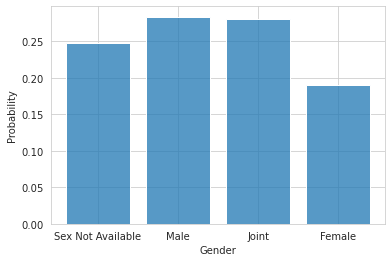

In [41]:
sns.histplot(x='Gender',data=df3f2.toPandas(), stat="probability",shrink=.8)  

<AxesSubplot:xlabel='loan_type', ylabel='Probability'>

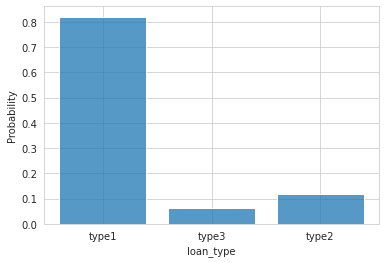

In [42]:
sns.histplot(x='loan_type',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='loan_purpose', ylabel='Probability'>

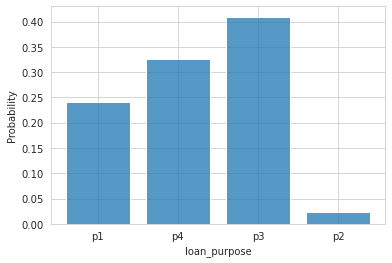

In [43]:
sns.histplot(x='loan_purpose',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='Credit_Worthiness', ylabel='Probability'>

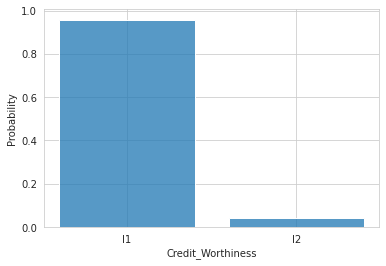

In [44]:
sns.histplot(x='Credit_Worthiness',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='term', ylabel='Probability'>

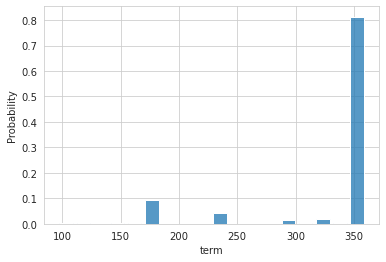

In [45]:
sns.histplot(x='term',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='Neg_ammortization', ylabel='Probability'>

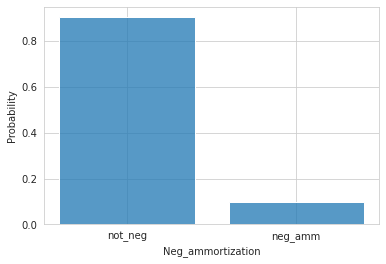

In [46]:
sns.histplot(x='Neg_ammortization',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='interest_only', ylabel='Probability'>

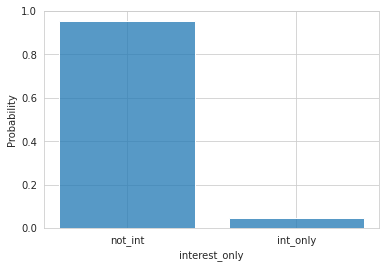

In [47]:
sns.histplot(x='interest_only',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='occupancy_type', ylabel='Probability'>

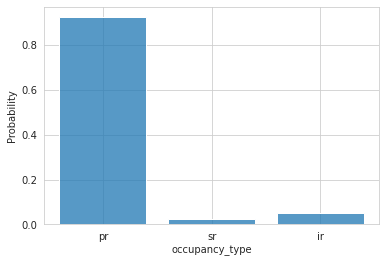

In [48]:
sns.histplot(x='occupancy_type',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='credit_type', ylabel='Probability'>

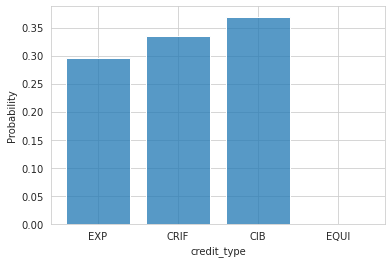

In [49]:
sns.histplot(x='credit_type',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='Credit_Score', ylabel='Probability'>

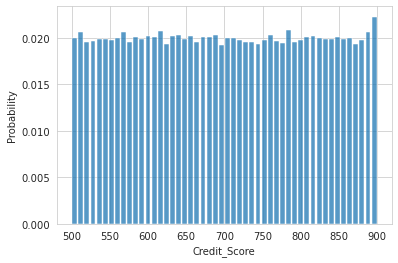

In [50]:
sns.histplot(x='Credit_Score',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='age', ylabel='Probability'>

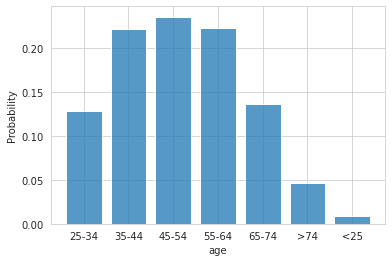

In [51]:
sns.histplot(x='age',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='Status', ylabel='Probability'>

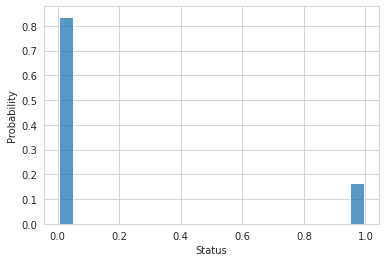

In [52]:
sns.histplot(x='Status',data=df3f2.toPandas(), stat="probability",shrink=.8)

<AxesSubplot:xlabel='dtir1', ylabel='Probability'>

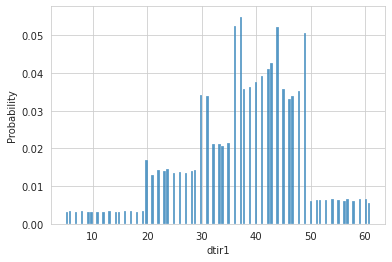

In [53]:
sns.histplot(x='dtir1',data=df3f2.toPandas(), stat="probability",shrink=.8)
#plt.show()

***Base de travail***

Avec df3f2 toutes les valeurs manquantes concernent des variables catégrielles. La transformation par one encoder générera des valeurs spécifiques pour valeurs manquantes. 

In [18]:
df3f2.toPandas().shape

(124549, 16)

Nous avons 124549 LIGNES

***Outliers***

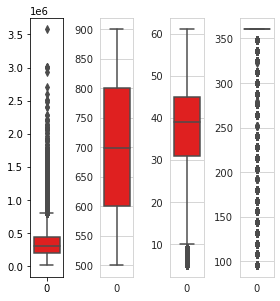

In [19]:
numcolDF3f2 = df3f2.toPandas()[['loan_amount', 'Credit_Score','dtir1','term']].copy()
l = numcolDF3f2.columns.values
number_of_columns=4
number_of_rows = round(len(l)-1/number_of_columns)
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows+1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data=numcolDF3f2[l[i]],color="red",orient="v")
    plt.tight_layout()

***CHOIX DE LA METHODE :***
- Notre variable d'intérêt (cible) est catégorielle: une regression linéaire par exemple n'est pas applicable.
- Remarque dans nos données, il y a une présence notable d'outliers. 
  - Même s'il n'y a pas d'accord, certains auteurs estiment que la regression logistique est plus sensible aux outliers que la classification par la forêt aléatoire. La classification par les forêts aléatoires est parfois utilisée pour détecter des outliers dans certaines modélisations
  - Par précaution, nous choississons une classification par la forêt aléatoire et nous ne tronquons nos données (Si nous voulions utiliser la regression logistique, nous nous occuperions des outliers).

***TRANSFORMATIONS***

In [990]:
#df3f2.columns

**Remplacer les null par des NA:**

Etape intégrée après

'**Complication technique :**'

Cela vise à permettre une affectation d'index même s'il y a une donnée manquante


In [ ]:
k = col("loan_purpose")
df3fna = df3f.withColumn("k", when(k.isNull(), "__NA__").otherwise(k))
k = col("Neg_ammortization")
df3fna = df3f.withColumn("k", when(k.isNull(), "__NA__").otherwise(k))
k = col("approv_in_adv")
df3fna = df3f.withColumn("k", when(k.isNull(), "__NA__").otherwise(k))
k = col("term")
df3fna = df3f.withColumn("k", when(k.isNull(), "__NA__").otherwise(k))
k = col("age")
df3fna = df3f.withColumn("k", when(k.isNull(), "__NA__").otherwise(k))
k = col("rate_of_interest")
df3fna = df3f.withColumn("k", when(k.isNull(), "__NA__").otherwise(k))

k = col("dtir1")
df3fna = df3f.withColumn("k", when(k.isNull(), "__NA__").otherwise(k))

***Indexation et encodage***

In [504]:
GenderIndexer = StringIndexer(inputCol="Gender", outputCol="Gender_Num")

In [505]:
GenderEncoder = OneHotEncoder(inputCols=["Gender_Num"], outputCols=["Gender_Num_Vector"])

In [506]:
CreditWorthinessIndexer = StringIndexer(inputCol="Credit_Worthiness", outputCol="Credit_Worthiness_Num")

In [507]:
CreditWorthinessEncoder = OneHotEncoder(inputCols=["Credit_Worthiness_Num"], 
                                        outputCols=["Credit_Worthiness_Num_Vector"],handleInvalid='keep')

In [508]:
NegammortizationIndexer = StringIndexer(inputCol="Neg_ammortization", 
                                        outputCol="Neg_ammortization_Num",handleInvalid ='keep')

In [509]:
NegammortizationEncoder = OneHotEncoder(inputCols=["Neg_ammortization_Num"],
                                        outputCols=["Neg_ammortization_Num_Vector"])

In [510]:
ageIndexer = StringIndexer(inputCol="age", outputCol="age_Num")

In [511]:
ageEncoder = OneHotEncoder(inputCols=["age_Num"], outputCols=["age_Num_Vector"])

In [512]:
approvinadvIndexer = StringIndexer(inputCol="approv_in_adv", outputCol="approv_in_adv_Num",handleInvalid ='keep')

In [513]:
approvinadvEncoder = OneHotEncoder(inputCols=["approv_in_adv_Num"], outputCols=["approv_in_adv_Num_Vector"])

In [514]:
coapplicantcredittypeIndexer = StringIndexer(inputCol="co-applicant_credit_type",
                                             outputCol="co-applicant_credit_type_Num")

In [515]:
coapplicantcreditEncoder = OneHotEncoder(inputCols=["co-applicant_credit_type_Num"], 
                                         outputCols=["co-applicant_credit_type_Num_Vector"])

In [516]:
credittypeIndexer = StringIndexer(inputCol="credit_type", outputCol="credit_type_Num")

In [517]:
credittypeEncoder = OneHotEncoder(inputCols=["credit_type_Num"], outputCols=["credit_type_Num_Vector"])

In [518]:
interestonlyIndexer = StringIndexer(inputCol="interest_only", outputCol="interest_only_Num")

In [519]:
interestonlyEncoder = OneHotEncoder(inputCols=["interest_only_Num"], outputCols=["interest_only_Num_Vector"])

In [520]:
loanpurposeIndexer = StringIndexer(inputCol="loan_purpose", outputCol="loan_purpose_Num",handleInvalid ='keep')

In [521]:
loanpurposeEncoder = OneHotEncoder(inputCols=["loan_purpose_Num"], outputCols=["loan_purpose_Num_Vector"])

In [522]:
loantypeIndexer = StringIndexer(inputCol="loan_type", outputCol="loan_type_Num")

In [523]:
loantypeEncoder = OneHotEncoder(inputCols=["loan_type_Num"], outputCols=["loan_type_Num_Vector"])

In [524]:
occupancytypeIndexer = StringIndexer(inputCol="occupancy_type", outputCol="occupancy_type_Num")

In [525]:
occupancytypeEncoder = OneHotEncoder(inputCols=["occupancy_type_Num"], outputCols=["occupancy_type_Num_Vector"])

***Assembler***

In [85]:
#df3f2.columns

In [132]:
df3f2.dtypes

[('Gender', 'string'),
 ('approv_in_adv', 'string'),
 ('loan_type', 'string'),
 ('loan_purpose', 'string'),
 ('Credit_Worthiness', 'string'),
 ('loan_amount', 'int'),
 ('term', 'double'),
 ('Neg_ammortization', 'string'),
 ('interest_only', 'string'),
 ('occupancy_type', 'string'),
 ('credit_type', 'string'),
 ('Credit_Score', 'int'),
 ('co-applicant_credit_type', 'string'),
 ('age', 'string'),
 ('Status', 'int'),
 ('dtir1', 'double')]

In [416]:
dfAssembler = VectorAssembler(inputCols=['Gender_Num_Vector', 'approv_in_adv_Num_Vector', 'loan_type_Num_Vector',
                                         'loan_purpose_Num_Vector', 'Credit_Worthiness_Num_Vector', 'loan_amount',
                                         'Neg_ammortization_Num_Vector', 'interest_only_Num_Vector', 
                                         'occupancy_type_Num_Vector', 'credit_type_Num_Vector', 'Credit_Score', 
                                         'co-applicant_credit_type_Num_Vector', 'age_Num_Vector', 'dtir1'],
                              handleInvalid = "keep", outputCol="features")

**Complication technique :**

Le vecteur assembleur refuse de fonctionner avec les données manquantes. 
- Nous allons avons donc remplacer les Null par des NA. 
- Cette opération force à considérer les NA comme une modalité. Cela équivaut, selon l'idée que je me fais, à un remplacement par une même valeur.
- Nous profitons réintégrer dans la liste la variable rat_of_interest en déclarant NA ces valeurs Null. La base de travail passe de df3f2 à **df3f**.
- Ces remplacements devraient être fait avant l'indexation.

Voir étape **Remplacer les null par des NA:** au dessus

***Variables candidates de base***

In [358]:
dfAssembler = VectorAssembler(inputCols=['Gender_Num_Vector', 'loan_type_Num_Vector',  'Credit_Worthiness_Num_Vector', 'loan_amount', 
                                         'interest_only_Num_Vector', 'occupancy_type_Num_Vector', 'credit_type_Num_Vector', 
                                         'Credit_Score', 'co-applicant_credit_type_Num_Vector', 'age_Num_Vector', 'dtir1'],
                              outputCol="features",handleInvalid = "skip")

***Recherche des features***

Notre stratégie de recherche est basée sur le 'ONe Leave Out'. 
- Nous enlevons une variable et nous regardons les conséquences sur les performances du modèle. En principe, les feathers importances devraient nous guider dans le choix des feathers mais nous n'avons pas pu exploiter cette possibilité.
- S'il n' y pas pas d'effet considérable, la variable sort de la liste des déterminants
- La dernière liste est celle à retenir pour l'estimation du modèle

In [ ]:
#moins le genre (car beaucoup genre non déclarer)#constat pas d'effet sur les metrics

In [239]:
dfAssembler = VectorAssembler(inputCols=[ 'loan_type_Num_Vector',  'Credit_Worthiness_Num_Vector', 'loan_amount', 
                                         'interest_only_Num_Vector', 'occupancy_type_Num_Vector', 
                                         'credit_type_Num_Vector', 'Credit_Score', 
                                         'co-applicant_credit_type_Num_Vector', 'age_Num_Vector', 
                                         'dtir1'], outputCol="features",handleInvalid = "skip")

In [ ]:
#moins occuppancy# constat détérioration

In [ ]:
dfAssembler = VectorAssembler(inputCols=['loan_type_Num_Vector',  'Credit_Worthiness_Num_Vector', 'loan_amount', 
                                         'interest_only_Num_Vector', 'credit_type_Num_Vector', 
                                         'Credit_Score', 'co-applicant_credit_type_Num_Vector', 
                                         'age_Num_Vector', 'dtir1'], outputCol="features",handleInvalid = "skip")

In [ ]:
#moins co-applicant #Léger baisse

In [291]:
dfAssembler = VectorAssembler(inputCols=[ 'loan_type_Num_Vector',  'Credit_Worthiness_Num_Vector', 'loan_amount', 
                                         'interest_only_Num_Vector',  'credit_type_Num_Vector', 
                                         'Credit_Score', 'age_Num_Vector', 'dtir1'],
                              outputCol="features",handleInvalid = "skip")

In [ ]:
#moins dtir1 #détérioration notable

In [296]:
dfAssembler = VectorAssembler(inputCols=['loan_type_Num_Vector',  'Credit_Worthiness_Num_Vector', 'loan_amount', 
                                         'interest_only_Num_Vector',  'credit_type_Num_Vector', 
                                         'Credit_Score', 'age_Num_Vector'], outputCol="features")

In [157]:
#moins interest only

In [317]:
dfAssembler = VectorAssembler(inputCols=['Gender_Num_Vector', 'loan_type_Num_Vector',  
                                         'Credit_Worthiness_Num_Vector', 'loan_amount', 
                                           'credit_type_Num_Vector', 
                                         'Credit_Score', 'dtir1'], outputCol="features")

In [ ]:
#moins worthiness baisse roc

In [565]:
dfAssembler = VectorAssembler(inputCols=['Gender_Num_Vector', 'loan_type_Num_Vector',  
                                         'approv_in_adv_Num_Vector',  
                                           'credit_type_Num_Vector',  'loan_amount',
                                         'loan_purpose_Num_Vector',
                                         'Neg_ammortization_Num_Vector','Credit_Score',
                                         'rate_of_interest'],handleInvalid = "keep", outputCol="features")

In [ ]:
#moins Neg_ammortization_Num_Vector #amélioration des stats

In [588]:
dfAssembler = VectorAssembler(inputCols=['Gender_Num_Vector', 'loan_type_Num_Vector',  'approv_in_adv_Num_Vector',  
                                           'credit_type_Num_Vector',  'loan_amount','loan_purpose_Num_Vector',
                                         'Credit_Score','rate_of_interest'],
                              handleInvalid = "keep", outputCol="features")

In [550]:
from pyspark.ml.feature import StandardScaler
#stdscaler = StandardScaler(InputCol="features", OutputCol="scaledFeatures", withMean=True, withStd=True)

In [557]:
standardScaler = StandardScaler()
scaler=standardScaler.setInputCol("features").setOutputCol("scaledFeatures").setWithStd(True).setWithMean(False)

***PIPELINE***

In [589]:
#rf = RandomForestClassifier(labelCol="Status", featuresCol="features", numTrees=4)
rf = RandomForestClassifier(labelCol="Status", featuresCol="scaledFeatures", #categoricalFeaturesInfo={},
                                     numTrees=10, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=10, maxBins=32)

In [590]:
# Pipeline Toutes les étapes précédantes
pipeline = Pipeline(stages=[GenderIndexer,GenderEncoder,
                            CreditWorthinessIndexer,CreditWorthinessEncoder,
                            NegammortizationIndexer,NegammortizationEncoder,
                            ageIndexer,ageEncoder,
                            approvinadvIndexer,approvinadvEncoder,
                            coapplicantcredittypeIndexer,coapplicantcreditEncoder,
                            credittypeIndexer,credittypeEncoder,
                            interestonlyIndexer,interestonlyEncoder,
                            loanpurposeIndexer,loanpurposeEncoder,
                            loantypeIndexer,loantypeEncoder,
                            occupancytypeIndexer,occupancytypeEncoder,
                            dfAssembler,scaler, rf])

***DIVISION DES DONNEES POUR LE TEST ET LE TRAIN***

In [584]:
trainDf, testDf = df3fna.randomSplit([0.75, 0.25])

***ESTIMATION DU MODELE***

In [591]:
# Training results
model = pipeline.fit(trainDf)

***EVALUATION DU MODELE***

In [592]:
trainingSummary = model.stages[-1].summary

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


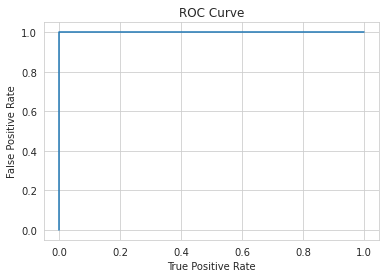

Training set areaUnderROC: 1.0


In [593]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [594]:
#--------------------------------------------------------------
# Résultats sur le test dataset
#--------------------------------------------------------------
results = model.transform(testDf)

results.select("Status","prediction","rawPrediction","probability").show(40, truncate=False)
y_true = results.select(['Status']).collect()
y_pred = results.select(['prediction']).collect()
predictionAndLabels= results.rdd.map(lambda row: (float(row.Status), row.prediction))

+------+----------+-----------------------------------------+------------------------------------------+
|Status|prediction|rawPrediction                            |probability                               |
+------+----------+-----------------------------------------+------------------------------------------+
|0     |0.0       |[10.0,0.0]                               |[1.0,0.0]                                 |
|0     |0.0       |[10.0,0.0]                               |[1.0,0.0]                                 |
|0     |0.0       |[10.0,0.0]                               |[1.0,0.0]                                 |
|0     |0.0       |[10.0,0.0]                               |[1.0,0.0]                                 |
|0     |0.0       |[9.999955257270694,4.47427293064877E-5]  |[0.9999955257270694,4.47427293064877E-6]  |
|0     |0.0       |[9.99943661971831,5.633802816901409E-4]  |[0.9999436619718309,5.6338028169014086E-5]|
|0     |0.0       |[9.999955257270694,4.47427293064877E

In [595]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28184
           1       1.00      0.98      0.99        42

    accuracy                           1.00     28226
   macro avg       1.00      0.99      0.99     28226
weighted avg       1.00      1.00      1.00     28226



Ce modèle nous permet d'avoir un ROC de 1 et une précision de 100% pour toutes les classes.  On devrait être statisfait. 
Toutefois, ce modèle nourrit des inquiétudes:
- La classe 1 est sous représentée: Par exemple dans l'échantillon de test ayant servi pour l'évation ci-dessus, on note 42 élements de classe 1 contre 28184 éléments de classe 0: soit (42/28226)*100=1,48 pour 1000.
 - En réalité, le problème se trouve aussi dans la base df3f servant de données pour le modèle. Les fitrages ayant aboutit à cette base conduisent à la structure suivante (voir ci-dessous): 200 valeurs de classe 1 contre 112031: soit 1,78 pour 1000. Cet écart est considérable par rapport à la structure de base où il y a près 24% d'éléments de classe 1. 
 - Notre inquiétude est qu'il n'ait pas assez de données de classe 1 pour entrainer le modèle.
 - Cette situation est la conséquence de la stratégie de gestion des données manquantes: retenir le moins possible de lignes avec des données manquantes: cela vise à avoir un résultat robuste. Mais dans notre cas, la perte d'informations est très importante.
 - Nous proposons donc de revoir les choix de gestion de données manquantes pour avoir un autre modèle de classification applicable au cas que le défaut de remboursement  n'est pas un phénomène aussi rare. Les deux sont complémataires.


In [993]:
df3f.groupBy("Status").count().show()  

+------+------+
|Status| count|
+------+------+
|     1|   200|
|     0|112031|
+------+------+



## ***GESTION DES DONNEES MANQUANTES (Boucle sélection des features)***
RECHERCCHE D'UNE BASE EQUILIBREE incluant le TAUX D'INTERÊT. CAR SEUL, IL DONNE DES STATS QUASI IDENTIQUES QUE CELLES SANS LES AUTRES VARIABLES
 - Notre stratégie de remplacement des données manquantes se déroule comme suit:
      - Pour les données de type numérique: il existe des méthodes de remplacement par la moyenne ou la médiane. Nous estimons que ces solutions apportent moins de variation à l'information utile à l'analyse. 
        - Nous proposons un remplacement par des valeurs choisies aléatoirement entre le premier quartile et le 3ème quartile. Peut-être qu'en faisant la moyenne de ces valeurs, (pas sûr) nous trouverons la moyenne de la variable. Dans ce cas, nous avons la même moyenne que la stratégie de remplacement par la moyenne; en plus, nous avons une variabilité de l'information.
        - Dans le cas où la plage entre les quartiles n'assure pas l'obtention d'une variabilité, nous considérons le minimum et le maximum comme les bornes au lieu du 1er quartile et le 3eme quartile.


      - Pour les données de ***type string** : nous remplaçons les données manquantes par les modalités de la variables choisies de manière aléatoire. 
        - La première étape consiste à affecter un numéro aléatoire à toute cellule vide de la colonne. 
        - La deuxième étape consiste à affecter une modalité à chaque numero en le remplaçant. 


Nous partons donc de notre base de données df3. 

Les variables concernées par les données manquantes seront  toutes traitées


**PRENDRE UNE PLAGE DE VALEURS pour rate_of_interest basée sur les quartiles**

In [613]:
freqrofi = df3.stat.approxQuantile("rate_of_interest", [0.0,0.25,0.5,0.75,1.0],0.0)
print(freqrofi)

[0.0, 3.625, 3.99, 4.375, 8.0]


Nou allons remplir les valeurs manquantes de manière aléatoire avec des valeurs comprises entre 3,625 (25%: permier quartile) et 4.375 (75%)

In [ ]:
#from pyspark.sql import functions as F
#from random import randint
    
#df.na.fill({'x4':randint(0,100)}).show()
#df.withColumn('x5', F.coalesce(F.col('x5'), (F.round(F.rand()*100)))).show()

**Remplacement aléatoire de valeurs comprises dans l'intervalle 1er quartile - 3eme quartile** 

In [638]:
from pyspark.sql import functions as F
from random import randint
#df3na=df3.fillna(randint(3, 4), 'rate_of_interest').show()
df3na=df3.withColumn('rate_of_interest_filled', F.coalesce(F.col('rate_of_interest').cast("double"), ((3.625) + 0.75*F.rand())))

In [743]:
#df3napd=df3na.toPandas()

In [744]:
#sns.histplot(x='rate_of_interest_filled',data=df3napd, stat="probability",shrink=.8)

In [745]:
#df3na.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df3na.columns]).show(vertical=True)

**PRENDRE UNE PLAGE DE VALEURS pour dtir1 basée sur les quartiles**

In [642]:
freqdtr1fi = df3.stat.approxQuantile("dtir1", [0.0,0.25,0.5,0.75,1.0],0.0)
print(freqdtr1fi)

[5.0, 31.0, 39.0, 45.0, 61.0]


**Remplacement aléatoire de valeurs comprises dans l'intervalle 1er quartile - 3eme quartile** 

In [647]:
df3na=df3na.withColumn('dtir1_filled', F.coalesce(F.col('dtir1'), F.round(((31) + 14*F.rand()))))

In [746]:
#df3na.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df3na.columns]).show(vertical=True)

**PRENDRE UNE PLAGE DE VALEURS pour term basée sur les quartiles**

In [987]:
freqdtrmfi = df3.stat.approxQuantile("term", [0.0,0.25,0.5,0.75,1.0],0.0)
print(freqdtrmfi)

[96.0, 360.0, 360.0, 360.0, 360.0]


Si nous appliquons le même principe, nous allons avoir uniquement 360 comme valeur de remplacement. 
Nous allons donc changer de stratégie pour avoir plus de variété. Nous allons considérer le min et le max comme bornes pour cette variable


**Remplacement aléatoire de valeurs comprises dans l'intervalle min - max** 

In [649]:
df3na=df3na.withColumn('term_filled', F.coalesce(F.col('term'), F.round(((96) + 264*F.rand()))))

In [747]:
#df3na.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df3na.columns]).show(vertical=True)

**POUR LES VARIABLES DE TYPES STRING: en deux étapes.** 
- Etape 1: génerer des nombres aléatoires dont le nombre de valeurs distinctes est égale au nombre de modalités distinctes de la variable.
- Etape 2: remplir une nouvelle colonne selon un schéma conditionnel de correpondance des modalités

**Voir les différentes modalités de la variables**

In [651]:
df3.groupBy("approv_in_adv").count().show() 

+-------------+------+
|approv_in_adv| count|
+-------------+------+
|         null|   908|
|        nopre|124621|
|          pre| 23141|
+-------------+------+



**Remplissage aléatoire de 1 à 2 des céllules vides**

In [758]:
df3na=df3na.withColumn('approv_in_adv_filled', F.coalesce(F.col('approv_in_adv'), F.round(((1) + F.rand()))))

In [708]:
df3na=df3na.withColumn('approv_in_adv_filled',col('approv_in_adv_filled').cast("String"))

In [699]:
#Pas fonctionner
#df3na=df3na.withColumn('approv_in_adv_filled2',when(df3na.approv_in_adv_filled == 1,df3na.approv_in_adv_filled).otherwise('nopre'))

In [ ]:
#Pas fonctionner
#df3na=df3na.withColumn('approv_in_adv_filled2',when(df3na.approv_in_adv_filled == 1,df3na.approv_in_adv_filled).otherwise('pre'))

**Affectation de modalités (de la variable) aux valeurs générées aléatoirement**

In [701]:
from pyspark.sql.functions import when

In [759]:
df3na = df3na.withColumn("approv_in_adv_filled", when(df3na.approv_in_adv_filled == "1.0","nopre") \
      .when(df3na.approv_in_adv_filled == "2.0","pre") \
      .otherwise(df3na.approv_in_adv_filled))

In [709]:
#Pas fonctionner
#df3na = df3na.withColumn( 'approv_in_adv_filled2', 
#                         F.coalesce(F.col('approv_in_adv_filled2'), 
#                                    F.when(F.col('approv_in_adv_filled') == "1", "nopre")
#                                     .when(F.col('approv_in_adv_filled') == "2", "pre")))

In [760]:
df3na.groupBy("approv_in_adv_filled").count().show() 

+--------------------+------+
|approv_in_adv_filled| count|
+--------------------+------+
|               nopre|125054|
|                 pre| 23616|
+--------------------+------+



**Voir les différentes modalités de la variables**

In [713]:
df3.groupBy("age").count().show() 

+-----+-----+
|  age|count|
+-----+-----+
|45-54|34720|
| null|  200|
|  <25| 1337|
|55-64|32534|
|  >74| 7175|
|35-44|32818|
|25-34|19142|
|65-74|20744|
+-----+-----+




**Remplissage aléatoire de 1 à 7 des céllules vides**

In [715]:
df3na=df3na.withColumn('age_filled', F.coalesce(F.col('age'), F.round(((1) + 6*F.rand()))))

In [716]:
df3na = df3na.withColumn("age_filled", when(df3na.age_filled == "1.0","<25") \
      .when(df3na.age_filled == "2.0","35-44") \
      .when(df3na.age_filled == "3.0","45-54") \
      .when(df3na.age_filled == "4.0","55-64") \
      .when(df3na.age_filled == "5.0","25-34") \
      .when(df3na.age_filled == "6.0","65-74") \
      .when(df3na.age_filled == "7.0",">74") \
      .otherwise(df3na.age_filled))

**Vérification**

In [717]:
df3na.groupBy("age_filled").count().show() 

+----------+-----+
|age_filled|count|
+----------+-----+
|     45-54|34742|
|       <25| 1350|
|     55-64|32563|
|       >74| 7196|
|     35-44|32857|
|     25-34|19182|
|     65-74|20780|
+----------+-----+



**Voir les différentes modalités de la variables**

In [718]:
df3.groupBy("Neg_ammortization").count().show() 

+-----------------+------+
|Neg_ammortization| count|
+-----------------+------+
|          neg_amm| 15129|
|             null|   121|
|          not_neg|133420|
+-----------------+------+



**Remplissage aléatoire de 1 à 2 des céllules vides**

In [734]:

df3na=df3na.withColumn('Neg_ammortization_filled', F.coalesce(F.col('Neg_ammortization'), F.round(((1) + F.rand()))))

**Affectation de modalités (de la variable) aux valeurs générées aléatoirement**

In [735]:
df3na = df3na.withColumn("Neg_ammortization_filled", when(df3na.Neg_ammortization_filled == "1.0","neg_amm") \
      .when(df3na.Neg_ammortization_filled == "2.0","not_neg") \
      .otherwise(df3na.Neg_ammortization_filled))

In [985]:
#df3na.drop('Neg_ammortization_filled2').columns

**Vérification**

In [737]:
df3na.groupBy("Neg_ammortization_filled").count().show() 

+------------------------+------+
|Neg_ammortization_filled| count|
+------------------------+------+
|                 neg_amm| 15188|
|                 not_neg|133482|
+------------------------+------+



**Voir les différentes modalités de la variable**

In [739]:
df3.groupBy("loan_purpose").count().show() 

+------------+-----+
|loan_purpose|count|
+------------+-----+
|        null|  134|
|          p2| 3274|
|          p1|34529|
|          p3|55934|
|          p4|54799|
+------------+-----+



**Remplissage aléatoire de 1 à 4 des céllules vides**

In [740]:
df3na=df3na.withColumn('loan_purpose_filled', F.coalesce(F.col('loan_purpose'), F.round(((1) + 3*F.rand()))))

**Affectation de modalités (de la variable) aux valeurs générées aléatoirement**

In [741]:
df3na = df3na.withColumn("loan_purpose_filled", when(df3na.loan_purpose_filled == "1.0","p2") \
      .when(df3na.loan_purpose_filled == "2.0","p1") \
      .when(df3na.loan_purpose_filled == "3.0","p3") \
      .when(df3na.loan_purpose_filled == "4.0","p4") \
      .otherwise(df3na.loan_purpose_filled))

**Vérification**

In [742]:
df3na.groupBy("loan_purpose_filled").count().show() 

+-------------------+-----+
|loan_purpose_filled|count|
+-------------------+-----+
|                 p2| 3290|
|                 p1|34586|
|                 p3|55975|
|                 p4|54819|
+-------------------+-----+



 ***VERIFICATION DES COMPTES:***

In [752]:
df3na=df3na.drop("Neg_ammortization_filled2") #redondance

In [756]:
df3na=df3na.drop("approv_in_adv_filled2") #redondance

In [761]:
df3na.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df3na.columns]).show(vertical=True)

-RECORD 0-------------------------
 Gender                   | 0     
 approv_in_adv            | 908   
 loan_type                | 0     
 loan_purpose             | 134   
 Credit_Worthiness        | 0     
 loan_amount              | 0     
 rate_of_interest         | 36439 
 term                     | 41    
 Neg_ammortization        | 121   
 interest_only            | 0     
 occupancy_type           | 0     
 credit_type              | 0     
 Credit_Score             | 0     
 co-applicant_credit_type | 0     
 age                      | 200   
 Status                   | 0     
 dtir1                    | 24121 
 rate_of_interest_filled  | 0     
 dtir1_filled             | 0     
 term_filled              | 0     
 age_filled               | 0     
 Neg_ammortization_filled | 0     
 loan_purpose_filled      | 0     
 approv_in_adv_filled     | 0     



On peut constater en bas de liste qu'il ne manque plus de données dans nos nouvelles variables

***Vérification de la répartition de la variable status***

In [763]:
df3na.groupBy("Status").count().show()  

+------+------+
|Status| count|
+------+------+
|     1| 36639|
|     0|112031|
+------+------+



Nous avons gardé la même répartition que la base de données d'origine

## ***TRANSFORMATION DES VARIABLES***

***Indexation et encodage: cette fois sans données manquantes***

Nous reprenons ici les mêmes transformations réalisées avec la démarche précédante

In [764]:
GenderIndexer = StringIndexer(inputCol="Gender", outputCol="Gender_Num")

In [765]:
GenderEncoder = OneHotEncoder(inputCols=["Gender_Num"], outputCols=["Gender_Num_Vector"])

In [766]:
CreditWorthinessIndexer = StringIndexer(inputCol="Credit_Worthiness", outputCol="Credit_Worthiness_Num")

In [767]:
CreditWorthinessEncoder = OneHotEncoder(inputCols=["Credit_Worthiness_Num"], 
                                        outputCols=["Credit_Worthiness_Num_Vector"],handleInvalid='keep')

In [768]:
NegammortizationIndexer = StringIndexer(inputCol="Neg_ammortization_filled", 
                                        outputCol="Neg_ammortization_filled_Num",handleInvalid ='keep')

In [769]:
NegammortizationEncoder = OneHotEncoder(inputCols=["Neg_ammortization_filled_Num"],
                                        outputCols=["Neg_ammortization_filled_Num_Vector"])

In [770]:
ageIndexer = StringIndexer(inputCol="age_filled", outputCol="age_filled_Num")

In [771]:
ageEncoder = OneHotEncoder(inputCols=["age_filled_Num"], outputCols=["age_filled_Num_Vector"])

In [772]:
approvinadvIndexer = StringIndexer(inputCol="approv_in_adv_filled", outputCol="approv_in_adv_filled_Num",handleInvalid ='keep')

In [773]:
approvinadvEncoder = OneHotEncoder(inputCols=["approv_in_adv_filled_Num"], outputCols=["approv_in_adv_filled_Num_Vector"])

In [774]:
coapplicantcredittypeIndexer = StringIndexer(inputCol="co-applicant_credit_type",
                                             outputCol="co-applicant_credit_type_Num")

In [775]:
coapplicantcreditEncoder = OneHotEncoder(inputCols=["co-applicant_credit_type_Num"], 
                                         outputCols=["co-applicant_credit_type_Num_Vector"])

In [776]:
credittypeIndexer = StringIndexer(inputCol="credit_type", outputCol="credit_type_Num")

In [777]:
credittypeEncoder = OneHotEncoder(inputCols=["credit_type_Num"], outputCols=["credit_type_Num_Vector"])

In [778]:
interestonlyIndexer = StringIndexer(inputCol="interest_only", outputCol="interest_only_Num")

In [779]:
interestonlyEncoder = OneHotEncoder(inputCols=["interest_only_Num"], outputCols=["interest_only_Num_Vector"])

In [780]:
loanpurposeIndexer = StringIndexer(inputCol="loan_purpose_filled", outputCol="loan_purpose_filled_Num",handleInvalid ='keep')

In [781]:
loanpurposeEncoder = OneHotEncoder(inputCols=["loan_purpose_filled_Num"], outputCols=["loan_purpose_filled_Num_Vector"])

In [782]:
loantypeIndexer = StringIndexer(inputCol="loan_type", outputCol="loan_type_Num")

In [783]:
loantypeEncoder = OneHotEncoder(inputCols=["loan_type_Num"], outputCols=["loan_type_Num_Vector"])

In [784]:
occupancytypeIndexer = StringIndexer(inputCol="occupancy_type", outputCol="occupancy_type_Num")

In [785]:
occupancytypeEncoder = OneHotEncoder(inputCols=["occupancy_type_Num"], outputCols=["occupancy_type_Num_Vector"])


***Assembler***

Liste des variables candidates issues de la première étape de la sélection des variables

In [786]:
##ROC et stats sur 1 légèrement moins reluisant que l'étape précédante mais forte représentation des 1
dfAssembler = VectorAssembler(inputCols=['Gender_Num_Vector', 'approv_in_adv_filled_Num_Vector', 'loan_type_Num_Vector', 'loan_purpose_filled_Num_Vector', 'Credit_Worthiness_Num_Vector', 'loan_amount', 'Neg_ammortization_filled_Num_Vector',
 'interest_only_Num_Vector', 'occupancy_type_Num_Vector', 'credit_type_Num_Vector', 'Credit_Score', 'co-applicant_credit_type_Num_Vector', 'age_filled_Num_Vector', 'dtir1_filled', 'term_filled','rate_of_interest_filled'],handleInvalid = "keep", outputCol="features")

In [810]:
#Variables du dernier modèle de la démarche précédante pour comparaison
dfAssembler = VectorAssembler(inputCols=['Gender_Num_Vector', 'loan_type_Num_Vector',  'approv_in_adv_filled_Num_Vector',  
                                           'credit_type_Num_Vector',  'loan_amount','loan_purpose_filled_Num_Vector',
                                         'Credit_Score','rate_of_interest_filled'],handleInvalid = "keep", outputCol="features")

   - Recherche de l'ensemble minimal de variables permettant d'avoir une meilleure performance
   - Nous partons du dernier modèle de la démarche précédente permettant d'avec une ROC de 1 et de bonnes stats sur la précision et la sensibilité du modèle de test
        - L'ajout de 'dtir1_filled' n'améliore pas les stats
        - La suppression du genre baisse les stats  pour 1.
        - Suppression du montant baisse de roc
        - Suppression du type de prêts baisse du roc et des stats de 1
        - Suppression du type de crédit  baisse du roc et les autres stats
        - Suppression de l'objectif du prêt: les stats sont à leurs meilleurs niveaux
        - Suppression du score de crédit : ROC et la précision pour 1 s'améliorent
        - Ajout de terme : améliore recall de 1 sans effet sur le ROC.
        - Ajout de age, baisse des stats
        - Ajout de occupancy, baisse des stats

***L'ensemble des variables retenues***

In [974]:
dfAssembler = VectorAssembler(inputCols=[ 'Gender_Num_Vector', 'loan_type_Num_Vector','approv_in_adv_filled_Num_Vector', 
                                           'credit_type_Num_Vector', 'loan_amount','term_filled',
                                         'rate_of_interest_filled'],handleInvalid = "keep", outputCol="features")

***Standardiser***

In [916]:
standardScaler = StandardScaler()
scaler=standardScaler.setInputCol("features").setOutputCol("scaledFeatures").setWithStd(True).setWithMean(False)

***PIPELINE***

In [975]:
rf = RandomForestClassifier(labelCol="Status", featuresCol="scaledFeatures", #categoricalFeaturesInfo={},
                                     numTrees=12, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=12, maxBins=32)

- Nous avons essayé différentes valeurs pour les paramètres numTrees, maxDepth et maxBins. 
- Les valeurs qui permettent d'avoir des meilleures performances du modèle sont celles retenues.

In [976]:
# Pipeline Toutes les étapes précédantes
pipeline = Pipeline(stages=[GenderIndexer,GenderEncoder,
                            CreditWorthinessIndexer,CreditWorthinessEncoder,
                            NegammortizationIndexer,NegammortizationEncoder,
                            ageIndexer,ageEncoder,
                            approvinadvIndexer,approvinadvEncoder,
                            coapplicantcredittypeIndexer,coapplicantcreditEncoder,
                            credittypeIndexer,credittypeEncoder,
                            interestonlyIndexer,interestonlyEncoder,
                            loanpurposeIndexer,loanpurposeEncoder,
                            loantypeIndexer,loantypeEncoder,
                            occupancytypeIndexer,occupancytypeEncoder,
                            dfAssembler,scaler, rf])

Pipeline des étapes : de l'indexation à la standardisation puis à l'estimation du modèle

***Division de la base de données en train et test***

In [791]:
trainDf, testDf = df3na.randomSplit([0.75, 0.25])

***Estimation du modèle d'entrainement***

In [977]:
model = pipeline.fit(trainDf)

## ***EVALUAATION DU MODELE***
***Pouvoir de classification du modèle d'entrainement***

In [978]:
trainingSummary = model.stages[-1].summary

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


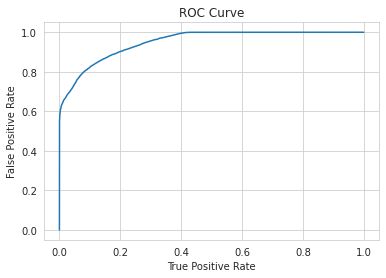

Training set areaUnderROC: 0.9503202889937541


In [979]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

***Evaluation modèle TEST***

In [980]:
#--------------------------------------------------------------
# Résultats sur le test dataset
#--------------------------------------------------------------
results = model.transform(testDf)

results.select("Status","prediction","rawPrediction","probability").show(40, truncate=False)
y_true = results.select(['Status']).collect()
y_pred = results.select(['prediction']).collect()
predictionAndLabels= results.rdd.map(lambda row: (float(row.Status), row.prediction))

+------+----------+----------------------------------------+-----------------------------------------+
|Status|prediction|rawPrediction                           |probability                              |
+------+----------+----------------------------------------+-----------------------------------------+
|0     |0.0       |[10.226006644260263,1.7739933557397365] |[0.8521672203550219,0.14783277964497804] |
|0     |0.0       |[9.291406204080381,2.7085937959196187]  |[0.7742838503400318,0.22571614965996822] |
|0     |0.0       |[9.640616634312634,2.359383365687366]   |[0.8033847195260528,0.19661528047394716] |
|1     |1.0       |[0.558838174273859,11.441161825726141]  |[0.046569847856154915,0.9534301521438451]|
|1     |1.0       |[0.558838174273859,11.441161825726141]  |[0.046569847856154915,0.9534301521438451]|
|0     |0.0       |[11.999399879975995,6.00120024004801E-4]|[0.9999499899979996,5.001000200040008E-5]|
|1     |1.0       |[0.558838174273859,11.441161825726141]  |[0.0465698478

***Rapport d'évaluation de modèle test***

In [981]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     28017
           1       0.98      0.60      0.74      9069

    accuracy                           0.90     37086
   macro avg       0.93      0.80      0.84     37086
weighted avg       0.91      0.90      0.89     37086



- Notre modèle a un taux d'erreur global de 10%. Avec ce modèle, on se trompe dans 10 cas classement sur 100 réalisés.
- Toutefois, la distribution par classe de notre variable de classification est non équilibré d'où la nécessité de voir la perfance du modèle par classe
    - Pour la classe 0 : dans 88% des cas, la classification à cette classe proposée par le modèle correspond à la bonne classe. De plus, toutes les personnes appartenant effectivement à cette classe sont classé à cette classe. 
    - Pour la classe 1 : le taux d'erreur est 2%. Cependant, le modèle permet de bien classer 60% des individus appartenant effectivement à cette classe. C'est le point faible du modèle : 40% des défauts de paiement ne sont pas correctement pris en compte par le modèle.  Il faut donc travailler à améliorer davantage le modèle en prenant en compte certaines caractéristiques importantes non présentes dans le modèle : seraient-elles perdues avec les données manquantes ? 
    - On constate que le modèle avec les données manquantes est moins performant que le modèle avec le moins de données manquantes